## Soical Network
### Build a Social Network and look at it through time.
Goals:
1. Build the network for each time-step
2. Use Community Detection Algos to cluster. Possibly use Core-periphery clustering instead (although this can probably just be done with centrality metrics)
3. Look at movement into core vs. periphery
4. Look at formation, splitting, merging of communities.

How:
1. Look at data [x]
2. See if it has user info [x]
3. See if it has info on which thread it was in. [x]
4. Chuck the data into time-steps (possibly over-lapping) [\_]
5. Create a directed link from writer towards all people who posted before them in a thread. [x]
6. Look at the network [x]
7. Cluster the network [x]
8. Look at the network thru time
9. Look at the clusters thru time

In [23]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
import nltk.sentiment.vader
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import community
import time
from sklearn.cluster import SpectralClustering
from sklearn import metrics
%matplotlib inline

In [3]:
dataset = pd.read_csv("csm subforums all posts cleaned.csv")

In [4]:
# dataset.head(10)

In [5]:
posts = dataset['Post']

#### Select posts during the incarna crisis
Do this for simplicity, we can expand it later.

In [6]:
# subset posts during the incarna crisis
dataset['Date_of_post'] =  pd.to_datetime(dataset['Date_of_post'],infer_datetime_format=True)


In [7]:
crisis_start = datetime.date(2011,3,1)
crisis_end = datetime.date(2011,9,1)
# (dataset['Date_of_post'].head() > crisis_start) & (dataset['Date_of_post'].head() < crisis_end)
mask = (crisis_start <= dataset['Date_of_post']) & (dataset['Date_of_post'] <= crisis_end)
posts_crisis = posts.loc[mask]
print('posts during crisis = ' + str( len(posts_crisis)))
posts_crisis.head()

posts during crisis = 32595


0    so we don't lose sight of all the summit topic...
1    what happened to the post of the long list of ...
2    csm5 was bad, fixing minor things/voting in th...
3    csm6 opted to forego player base consideration...
4    actually, you'll find that the topics we plan ...
Name: Post, dtype: object

### Let us start with non-directed affiliation networks first (they seem easier)
Create a link between people who posted in the same thread.
Plan ahead and put the other relevant info in the thread dict (date, post id)

In [63]:
df_sorted = dataset.sort_values(['all_thread_ids','Date_of_post'], ascending=[True, True])
df_sorted = df_sorted.reset_index()
# df_sorted

Analyzing the social network of all the posts was too computationally intensive and didn't complete. So I will chunk the posts into 1-week segments and see if it works.

Actually let's try 10k post segments and see if it works.

In [90]:
earliest = min(df_sorted['Date_of_post'])

In [129]:
start_time = time.time()


# This depends on the data frame to be sorted by thread first, then date


# create a dict of threads
thread_user = {}
# create a dict of user_to_thread
user_to_thread = {}
# create a dict of user_to_user
user_user_links = {} # (FROM,TO)
# place a link (or weight) from a user to all users above him in the thread(?)
last_thread_id = 0
last_date = datetime.datetime(1900,1,1) # set early date
same_day = False
users_in_thread_today = set() # set of users who posted today so ostensibly saw my post
users_before_me = set() # set of users who posted in the thread already

# for row_num in range(len(df_sorted)):
for row_num in range(1000):
    if row_num % 100 == 0:
        print(row_num)
    row = dataset.loc[row_num]
    this_user = row['Username']
    thread_ID = row['all_thread_ids']
    post_date = row['Date_of_post']
    
    
    if last_thread_id != thread_ID:
        users_in_thread_today = set() # set of users who posted today so ostensibly saw my post
        users_before_me = set() # set of users who posted in the thread already
    
    if last_date != post_date:
        users_in_thread_today = set()
    
    # put a link to all users ahead of me.
    for prior_commenter in users_before_me:
        if prior_commenter != this_user:
            if (this_user,prior_commenter) in user_user_links:
                user_user_links[(this_user,prior_commenter)][0] += 1
            else:
                user_user_links[(this_user,prior_commenter)] = [1,this_user,prior_commenter,thread_ID]
    
    # put a back link to me from all users in thread on same day. (ppl posting today may have seen this post)
    for prior_commenter in users_in_thread_today:
        if prior_commenter != this_user:
            if (prior_commenter,this_user) in user_user_links:
                user_user_links[(prior_commenter,this_user)][0] += 1
            else:
                user_user_links[(prior_commenter,this_user)] = [1,prior_commenter,this_user,thread_ID]
        
    # update this info to be the "last" for the next row
    prior_commenter = this_user
    last_date = post_date
    last_thread_id = thread_ID
    users_in_thread_today.add(this_user)
    users_before_me.add(this_user)
    
print("Done!")

end_time = time.time()
print(str(round(end_time - start_time,1)) + " seconds")

0
100
200
300
400
500
600
700
800
900
Done!
2.5 seconds


In [130]:
user_user_links_df = pd.DataFrame.from_dict(user_user_links, orient='index')#,columns=['weight', 'From', 'To'])
user_user_links_df.columns = ['weight', 'From', 'To','Thread']


In [131]:
user_user_links_df

,weight,From,To,Thread
"(Kethas Protagonist, Kel Archangel)",1,Kethas Protagonist,Kel Archangel,1555249
"(Planetary Genocide, Druthellion)",1,Planetary Genocide,Druthellion,1555249
"(ilammy's slave, Alexa Monk)",1,ilammy's slave,Alexa Monk,1555249
"(Kubiq, KayTwoEx)",1,Kubiq,KayTwoEx,1555249
"(d4shing, Varrent)",1,d4shing,Varrent,1555249
"(Aus Mote, Spinnakers)",1,Aus Mote,Spinnakers,1555249
"(Akiko Hanari, Super Chair)",1,Akiko Hanari,Super Chair,1555249
"(Alexa Monk, Almost29)",1,Alexa Monk,Almost29,1555249
"(Eerulee, Hirana Yoshida)",1,Eerulee,Hirana Yoshida,1555249
"(Arskaff, Casheddy)",1,Arskaff,Casheddy,1555249


In [132]:
n_nodes = len(user_user_links_df['From'].unique())
n_links = len(user_user_links_df)

In [133]:
n_links/(n_nodes*n_nodes)

0.5625366593215918

In [134]:
user_user_links_df

,weight,From,To,Thread
"(Kethas Protagonist, Kel Archangel)",1,Kethas Protagonist,Kel Archangel,1555249
"(Planetary Genocide, Druthellion)",1,Planetary Genocide,Druthellion,1555249
"(ilammy's slave, Alexa Monk)",1,ilammy's slave,Alexa Monk,1555249
"(Kubiq, KayTwoEx)",1,Kubiq,KayTwoEx,1555249
"(d4shing, Varrent)",1,d4shing,Varrent,1555249
"(Aus Mote, Spinnakers)",1,Aus Mote,Spinnakers,1555249
"(Akiko Hanari, Super Chair)",1,Akiko Hanari,Super Chair,1555249
"(Alexa Monk, Almost29)",1,Alexa Monk,Almost29,1555249
"(Eerulee, Hirana Yoshida)",1,Eerulee,Hirana Yoshida,1555249
"(Arskaff, Casheddy)",1,Arskaff,Casheddy,1555249


In [135]:
print(min(user_user_links_df['weight']))
# print(np.median(user_user_links_df['weight']))
print(np.mean(user_user_links_df['weight']))
print(max(user_user_links_df['weight']))


1
1.0237409629603063
33


In [136]:
start_time = time.time()
# print(start_time)

# Creating a Graph 
diG=nx.from_pandas_dataframe(user_user_links_df, 'From', 'To', ['weight'],create_using=nx.DiGraph())
unG=nx.from_pandas_dataframe(user_user_links_df, 'From', 'To', ['weight'])

end_time = time.time()
print("Done!")
print(str(round(end_time - start_time,1)) + " seconds")

# for 2k cells, 32 seconds
# for 10k cells, 29 seconds

Done!
5.3 seconds


(array([ 128.,   39.,    0.,    0.,    0.,    0.,    0.,  553.,  109.,    4.]),
 array([   0. ,   76.9,  153.8,  230.7,  307.6,  384.5,  461.4,  538.3,
         615.2,  692.1,  769. ]),
 <a list of 10 Patch objects>)

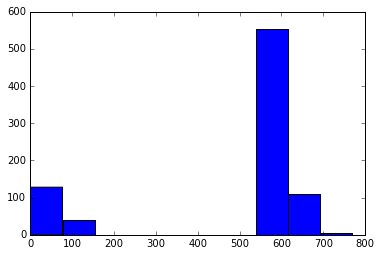

In [142]:
len(diG.nodes())
diG.degree()
plt.hist(list(diG.in_degree().values()))

It looks like the degrees (in degrees especially) are super skewed high - probably there were some threads that had ~ 600-800 users. If most of them posted on the same day then that is where most of the diadic links would come from. REALLY probably better to do Bi-partite affiliation networks. Then harder to measure "upstream" commenters as easily- what if someone just posts a lot in all the relevant things, but is a rando- they would appear to have very high centrality.

In [138]:
start_time = time.time()
print(start_time)

# compute eigenvalue centrality for the nodes
eig_cent = nx.eigenvector_centrality(diG)

end_time = time.time()
print("Done!")
print(str(round(end_time - start_time,1)) + " seconds")

# for 2k cells, 33 seconds

1544221411.562463
Done!
3.6 seconds


In [139]:
# start_time = time.time()
# print(start_time)

# nx.draw(diG,with_labels=False)
# end_time = time.time()
# print(end_time - start_time)

# # 45 sec for 1000 nodes

In [140]:
start_time = time.time()
partition = community.best_partition(unG)
community_id = [partition.get(node) for node in unG.nodes()]

end_time = time.time()
print("Done!")
print(str(round(end_time - start_time,1)) + " seconds")

# 7 sec for 1000 nodes

Done!
7.8 seconds


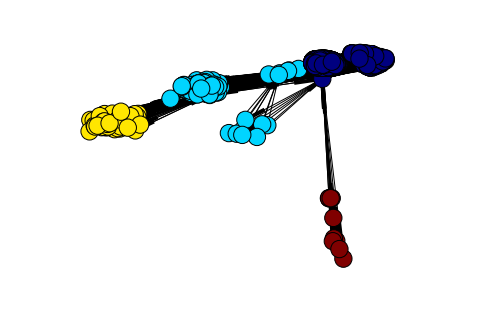

In [141]:
nx.draw(diG,with_labels=False,node_color=community_id)

In [124]:
# nx.draw(unG,with_labels=False,node_color=community_id)

In [125]:


start_time = time.time()

n_clusters = len(set(community_id))

# Get adjacency-matrix as numpy-array
adj_mat = nx.to_numpy_matrix(unG,weight='weights')

# Cluster
sc = SpectralClustering(n_clusters, affinity='precomputed', n_init=100)
sc.fit(adj_mat)

# sc = SpectralClustering(n_clusters, affinity='precomputed', n_init=100)
end_time = time.time()
print("Done!")
print(str(round(end_time - start_time,1)) + " seconds")

Done!
0.5 seconds


//anaconda/lib/python3.5/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


1544221362.58909
Done!
0.6 seconds


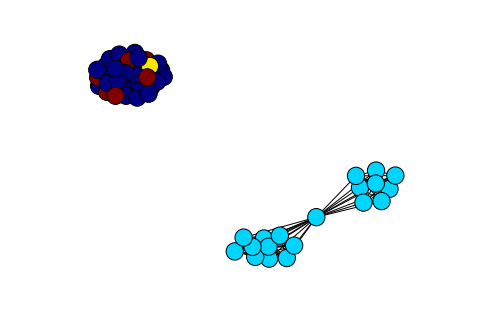

In [126]:
start_time = time.time()
print(start_time)

nx.draw(unG,with_labels=False,node_color=sc.labels_)
end_time = time.time()
print("Done!")
print(str(round(end_time - start_time,1)) + " seconds")

Done!
0.2 seconds


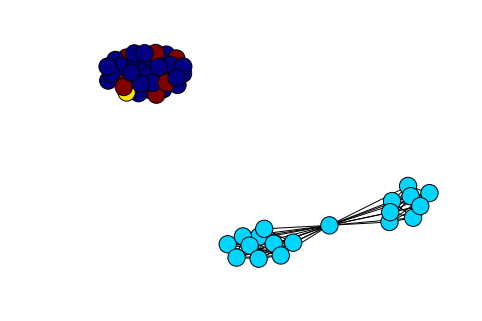

In [127]:
start_time = time.time()

nx.draw(unG,with_labels=False,node_color=sc.labels_)

end_time = time.time()
print("Done!")
print(str(round(end_time - start_time,1)) + " seconds")

Done!
0.5 seconds


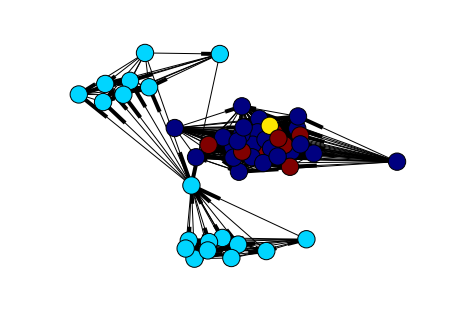

In [128]:
start_time = time.time()

nx.draw(diG,with_labels=False,node_color=sc.labels_)

end_time = time.time()
print("Done!")
print(str(round(end_time - start_time,1)) + " seconds")

ValueError: Color array must be two-dimensional

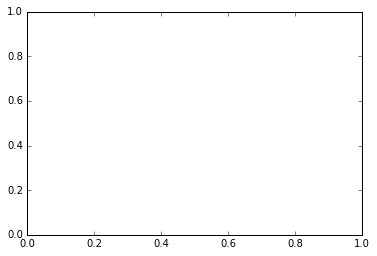

In [46]:
# nx.draw(unG,with_labels=False,node_color=list(parts.values()))

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(unG)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(unG, pos, list_nodes, node_size = 20,
                                node_color = np.array(list(partition.values())))


nx.draw_networkx_edges(unG, pos, alpha=0.5)
plt.show()

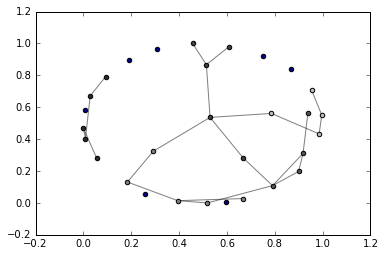

In [12]:
# Replace this with your networkx graph loading depending on your format !
G = nx.erdos_renyi_graph(30, 0.05)

#first compute the best partition
partition = community.best_partition(G)

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))


nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [12]:
# # writing the posts to an external file to be called by the VADER sentiment analyzer?

# file = open("posts_crisis.txt","w")
# file.write(posts[0])
# file.close()


In [13]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

In [14]:
def print_sentiment_scores(sentence):
    snt = analyser.polarity_scores(sentence)
    

In [15]:
# test out the sentiment analyzer on the first 100 posts
y = posts_crisis[0:100].apply(analyser.polarity_scores)
y[0]

{'compound': 0.996, 'neg': 0.013, 'neu': 0.801, 'pos': 0.186}

In [16]:
N = len(posts_crisis)
compound = [None for i in range(N)]
negative = [None for i in range(N)]
neutral = [None for i in range(N)]
positive = [None for i in range(N)]

In [17]:
# Very slow. Roughly 20 mins to process 318k posts @ 16k posts/min
start = datetime.datetime.now()
i = 0
for post in posts_crisis: # note, can't index by i
    
    try:
        scores = analyser.polarity_scores(post)
        compound[i] = scores["compound"]
        negative[i] = scores["neg"]
        neutral[i] = scores["neu"]
        positive[i] = scores["pos"]
    except:
        print("exception at: "+str(i))
    if i%1000 == 0:
        print(str(i)+" posts   ||   time = "+str(datetime.datetime.now()-start))
    i = i + 1
print("Sentiment Analysis - Done.")

0 posts   ||   time = 0:00:00.034828
1000 posts   ||   time = 0:00:01.198975
2000 posts   ||   time = 0:00:01.481619
3000 posts   ||   time = 0:00:01.841663
4000 posts   ||   time = 0:00:02.043579
5000 posts   ||   time = 0:00:02.458258
6000 posts   ||   time = 0:00:08.504894
7000 posts   ||   time = 0:00:14.900803
8000 posts   ||   time = 0:00:15.431817
9000 posts   ||   time = 0:00:15.827493
10000 posts   ||   time = 0:00:16.586868
11000 posts   ||   time = 0:00:19.685663
12000 posts   ||   time = 0:00:25.341852
13000 posts   ||   time = 0:00:30.623273
14000 posts   ||   time = 0:00:42.263083
15000 posts   ||   time = 0:00:50.784501
16000 posts   ||   time = 0:01:00.780555
17000 posts   ||   time = 0:01:05.780486
18000 posts   ||   time = 0:01:09.654388
19000 posts   ||   time = 0:01:12.765243
20000 posts   ||   time = 0:01:16.794096
21000 posts   ||   time = 0:01:21.047004
22000 posts   ||   time = 0:01:24.840109
23000 posts   ||   time = 0:01:28.303425
24000 posts   ||   time = 0:0

In [18]:
sentiment_scores = pd.DataFrame({'compound':compound,'negative':negative,'neutral':neutral,'positive':positive})
sentiment_scores.head()

,compound,negative,neutral,positive
0,0.9960,0.013,0.801,0.186
1,0.0000,0.000,1.000,0.000
2,-0.6908,0.256,0.659,0.084
3,0.9275,0.034,0.767,0.199
4,0.0000,0.000,1.000,0.000


In [19]:
len(sentiment_scores) == len(posts_crisis)

True

In [20]:
dataset_sent = dataset.loc[mask].join(sentiment_scores)
dataset_sent.head()

,Unnamed: 0,ID,Subforum,subsectionpage,all_thread_ids,Thread_Title,Thread_Page,Date_of_post,Username,Post,...,Exclam,Dash,Quote,Apostro,Parenth,OtherP,compound,negative,neutral,positive
0,1,1,Assembly Hall,1,1498941,[csm6] may summit topics thread index,1,2011-04-19,Killer2,so we don't lose sight of all the summit topic...,...,"0,00","0,30","1,20","3,61","0,90","0,30",0.9960,0.013,0.801,0.186
1,2,2,Assembly Hall,1,1498941,[csm6] may summit topics thread index,1,2011-04-21,Shepard Book,what happened to the post of the long list of ...,...,"0,00","0,00","0,00","0,00","0,00","0,00",0.0000,0.000,1.000,0.000
2,3,3,Assembly Hall,1,1498941,[csm6] may summit topics thread index,1,2011-04-22,Olivia Ironsides,"csm5 was bad, fixing minor things/voting in th...",...,"0,00","0,00","0,00","0,00","9,09","4,55",-0.6908,0.256,0.659,0.084
3,4,4,Assembly Hall,1,1498941,[csm6] may summit topics thread index,1,2011-04-25,Consortium Agent,csm6 opted to forego player base consideration...,...,"0,00","0,00","0,00","2,53","2,53","0,00",0.9275,0.034,0.767,0.199
4,5,5,Assembly Hall,1,1498941,[csm6] may summit topics thread index,1,2011-04-25,Killer2,"actually, you'll find that the topics we plan ...",...,"0,00","2,33","0,00","2,33","0,00","0,00",0.0000,0.000,1.000,0.000


In [21]:
dataset_sent = dataset_sent.dropna()

In [22]:
dataset_sent.to_csv('posts_during_incarna_crisis_with_sentiment_scores.csv')

#### Aside: Visualization

In [23]:
dataset2 = dataset_sent.groupby([pd.Grouper(key='Date_of_post', freq='W-MON')])['negative','positive'].mean().reset_index().sort_values('Date_of_post')


In [24]:
window = 2

ds2 = dataset2.dropna()
ds3 = ds2.loc[:,ds2.columns!="Date_of_post"].rolling(window).mean().dropna()
ds3 = ds3.join(ds2["Date_of_post"])

//anaconda/lib/python3.5/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


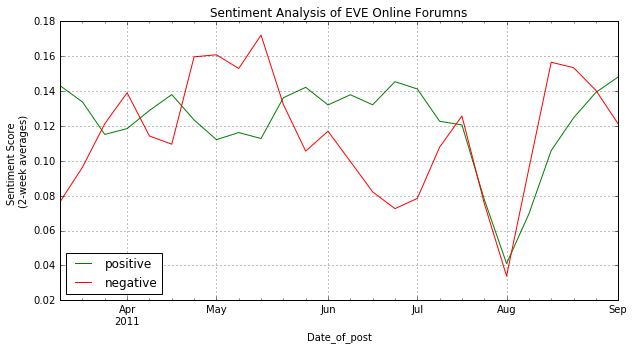

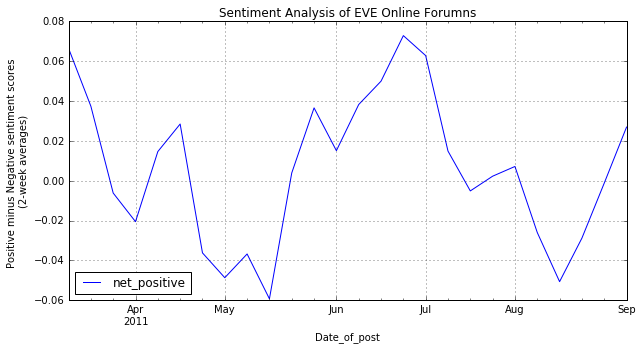

In [25]:
plt.rcParams['figure.figsize'] = [10, 5]
# plt.subplots(2, 2, sharex='col')

title_txt = 'Sentiment Analysis of EVE Online Forumns'

ds3.plot.line(x='Date_of_post',y=['positive','negative'], style=['g-','r-'])
plt.title(title_txt)
plt.ylabel('Sentiment Score \n('+str(window)+'-week averages)')
plt.legend(loc=3)
plt.grid()


cname = "net_positive"
ds4 = ds3
ds4[cname] = ds3['positive']-ds3['negative']
ds4.plot.line(x='Date_of_post',y=cname)
plt.grid()
plt.title(title_txt)
plt.ylabel('Positive minus Negative sentiment scores \n('+ str(window) + '-week averages)')
plt.legend(loc=3)

# plt.show()

### Select comments that match the date and rate above some threshold for negativity on sentiment


In [26]:
dsneg = dataset_sent.sort_values("negative",ascending=False)
for post in dsneg["Post"].head():
    print(post)
    print()

it is adorable that 95% of the people in this thread have missed the op's point entirely.he is not complaining about cloaking mechanics.he is not complaining about risk vs. reward in nullsec.he is not complaining about local.he is not complaining about enemies in his home systems.he is complaining about afk'ers. simple solution: a timed afk flag.

you do realize that, in the two years+ that i've been playing, i have found more people who do highsec industry that agree that it is barely profitable, even with the refining at stations. i've also experimented with it personally, and found that, (unless you have a lot of people doing something for nothing for a corp), aquiring the minerals and building anything is time consuming and very nearly a waste of time. actually, it is a waste of time, and it amazes me that people still do it.you can put a buy order out for anykind of mineral and spreadsheet everything to cost calculation vs. potential sale value of product, and work in a profit mar

#### Commentary:
Looking at this post at least, there does seem to be some negative sentiment or at least somewhat raised emotion. Let's move forward with the topic analysis.

Why not just start with topic analysis (or Nomological Network Analysis) and see which topics are associated with negativity? Maybe we will re-discover the mechanics behind the Sentiment analyzer, but maybe we will see some interesting stuff too.

### Topic Modeling

In [27]:
# From https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
# didn't have gensim pre-loaded so went to terminal and installed it with $pip install gensim

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nicholas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [28]:
documents = dsneg[["Post","negative"]]
documents = documents.reset_index(drop=True)
documents

,Post,negative
0,it is adorable that 95% of the people in this ...,1.0
1,"you do realize that, in the two years+ that i'...",1.0
2,the problem has more to do with the low end mi...,1.0
3,"as for missing dominion features, what about t...",1.0
4,ok this is cool and all but can you first ligh...,1.0
5,"i live in a 0.0 npc sov area, my alliance has ...",1.0
6,starbase (pos) refiningstarbases should be cap...,1.0
7,i see no problem here. sticking a cloaked alt ...,1.0
8,they are doing something about it? where is yo...,1.0
9,my suggestion is some asset accesible by accel...,1.0


Write a function to perform lemmatize and stem preprocessing steps on the data set.



In [29]:
def lemmatize_stemming(text):
    stemmer = SnowballStemmer("english")
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result


Select a document to preview after preprocessing.



In [30]:
doc_sample = documents.loc[0][0]
print('original document: ')
print(doc_sample)
words = []
for word in doc_sample.split(' '):
    words.append(word)
# print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
it is adorable that 95% of the people in this thread have missed the op's point entirely.he is not complaining about cloaking mechanics.he is not complaining about risk vs. reward in nullsec.he is not complaining about local.he is not complaining about enemies in his home systems.he is complaining about afk'ers. simple solution: a timed afk flag.


 tokenized and lemmatized document: 
['ador', 'peopl', 'thread', 'miss', 'point', 'entir', 'complain', 'cloak', 'mechan', 'complain', 'risk', 'reward', 'nullsec', 'complain', 'local', 'complain', 'enemi', 'home', 'system', 'complain', 'simpl', 'solut', 'time', 'flag']


#### commentary: 
We might not what to use stemming since it obscures what is being talked about and leaves out local-specific language (like 'afk'). But for now we can live with it.

Preprocess the headline text, saving the results as ‘processed_docs’   

In [31]:
processed_docs = documents['Post'].map(preprocess)
processed_docs[:10]

0    [ador, peopl, thread, miss, point, entir, comp...
1    [realiz, year, play, peopl, highsec, industri,...
2    [problem, miner, null, basic, right, mind, vel...
3    [miss, dominion, featur, treati, allow, simpl,...
4    [cool, lighten, anom, nerf, work, farm, field,...
5    [live, area, allianc, year, system, problem, c...
6    [starbas, capabl, refin, perfect, level, skill...
7    [problem, stick, cloak, monitor, happen, recon...
8    [sourc, nerf, local, incom, chang, local, issu...
9    [suggest, asset, acces, acceler, gate, let, pe...
Name: Post, dtype: object

##### Bag of Words on the Data set
Create a dictionary from ‘processed_docs’ containing the number of times a word appears in the training set.

In [32]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

16442 rahn
16626 calana
3685 nothi
11540 automobil
3037 asign
4187 kokobear
22169 zonera
21259 exzessiv
4977 radic
21194 melkavia
9697 notwithstand


##### Filter out tokens that appear in
- less than 15 documents (absolute number) or
- more than 50% of documents (fraction of total corpus size, not absolute number).
- after the above two steps, keep only the first 100000 most frequent tokens.

In [33]:
print("old len: "+ str(len(dictionary)))
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
print("new len: "+ str(len(dictionary)))


old len: 22248
new len: 2598


For each document we create a dictionary reporting how many
words and how many times those words appear. Save this to ‘bow_corpus’ (bow = bag of words), then check our selected document earlier.

In [34]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[0]

[(0, 1),
 (1, 5),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1)]

In [35]:
bow_doc_0 = bow_corpus[0]
for i in range(len(bow_doc_0)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_0[i][0], 
                                               dictionary[bow_doc_0[i][0]], 
bow_doc_0[i][1]))

Word 0 ("cloak") appears 1 time.
Word 1 ("complain") appears 5 time.
Word 2 ("enemi") appears 1 time.
Word 3 ("entir") appears 1 time.
Word 4 ("flag") appears 1 time.
Word 5 ("home") appears 1 time.
Word 6 ("local") appears 1 time.
Word 7 ("mechan") appears 1 time.
Word 8 ("miss") appears 1 time.
Word 9 ("nullsec") appears 1 time.
Word 10 ("peopl") appears 1 time.
Word 11 ("point") appears 1 time.
Word 12 ("reward") appears 1 time.
Word 13 ("risk") appears 1 time.
Word 14 ("simpl") appears 1 time.
Word 15 ("solut") appears 1 time.
Word 16 ("system") appears 1 time.
Word 17 ("thread") appears 1 time.
Word 18 ("time") appears 1 time.


Create tf-idf model object using models.TfidfModel on ‘bow_corpus’ and save it to ‘tfidf’, then apply transformation to the entire corpus and call it ‘corpus_tfidf’. Finally we preview TF-IDF scores for our first document.

TFIDF normalizes the counts of a word in each document by the word's relative rarity in the corpus. Therefore, common words are given lower wieght, and rare words are given more weight in each document.

In [36]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break


[(0, 0.11870616651557561),
 (1, 0.83206526583680107),
 (2, 0.14659226614704279),
 (3, 0.13789222110301583),
 (4, 0.18780949040708156),
 (5, 0.17607584899924361),
 (6, 0.12256850935619033),
 (7, 0.11289881518765715),
 (8, 0.14448963145642998),
 (9, 0.14213618336324435),
 (10, 0.074700190520057871),
 (11, 0.090403127686528625),
 (12, 0.14408518023312056),
 (13, 0.12468972388219712),
 (14, 0.12735631053513005),
 (15, 0.13555094640193577),
 (16, 0.13168860356132106),
 (17, 0.10380164255871836),
 (18, 0.071952583325137223)]


##### Running LDA using Bag of Words
Train our lda model using gensim.models.LdaMulticore and save it to ‘lda_model’

In [37]:
n_topics = 100
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=n_topics, id2word=dictionary, passes=2, workers=2)


//anaconda/lib/python3.5/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


Note the number of topics that were chosen above. Using more topics can discover more fine-grained and interesting themes, but also has a chance at discovering words that seemed to clump together just due to noise.

For each topic, we will explore the words occuring in that topic and its relative weight.

In [38]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))
    print()

Topic: 0 
Words: 0.026*"battleship" + 0.019*"dread" + 0.015*"ship" + 0.014*"mark" + 0.014*"kill" + 0.011*"coupl" + 0.011*"corp" + 0.010*"issu" + 0.010*"peac" + 0.009*"hour"

Topic: 1 
Words: 0.045*"like" + 0.023*"game" + 0.020*"sound" + 0.019*"good" + 0.015*"look" + 0.015*"best" + 0.014*"space" + 0.013*"newslett" + 0.012*"danger" + 0.012*"peopl"

Topic: 2 
Words: 0.065*"skill" + 0.037*"year" + 0.033*"train" + 0.029*"remap" + 0.023*"point" + 0.023*"game" + 0.023*"month" + 0.020*"time" + 0.014*"player" + 0.012*"learn"

Topic: 3 
Words: 0.019*"reward" + 0.015*"think" + 0.015*"sit" + 0.013*"peopl" + 0.011*"risk" + 0.011*"fleet" + 0.010*"choos" + 0.010*"high" + 0.010*"time" + 0.010*"popul"

Topic: 4 
Words: 0.027*"toon" + 0.019*"time" + 0.016*"like" + 0.015*"know" + 0.011*"want" + 0.011*"plex" + 0.010*"option" + 0.010*"chang" + 0.009*"say" + 0.009*"player"

Topic: 5 
Words: 0.142*"plex" + 0.018*"game" + 0.017*"expans" + 0.017*"parti" + 0.016*"sell" + 0.016*"buy" + 0.014*"group" + 0.014*"mar

Running LDA using TF-IDF



In [39]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=100, id2word=dictionary, passes=4, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.022*"thought" + 0.016*"frustrat" + 0.015*"payment" + 0.015*"apart" + 0.014*"cheat" + 0.014*"knowledg" + 0.014*"cooldown" + 0.014*"prefer" + 0.012*"bloodlin" + 0.012*"bpos"
Topic: 1 Word: 0.734*"cosmet" + 0.017*"price" + 0.005*"money" + 0.005*"reason" + 0.005*"stay" + 0.005*"multipli" + 0.004*"discourag" + 0.004*"believ" + 0.004*"agreement" + 0.004*"affect"
Topic: 2 Word: 0.021*"amarr" + 0.016*"day" + 0.011*"oper" + 0.010*"buddi" + 0.010*"event" + 0.009*"drug" + 0.009*"column" + 0.009*"suppos" + 0.009*"block" + 0.009*"refin"
Topic: 3 Word: 0.086*"listen" + 0.030*"concept" + 0.030*"rise" + 0.023*"servic" + 0.019*"havent" + 0.019*"blind" + 0.019*"solo" + 0.018*"pure" + 0.018*"communiti" + 0.015*"frigat"
Topic: 4 Word: 0.031*"expand" + 0.020*"throw" + 0.020*"inevit" + 0.015*"gotta" + 0.014*"permiss" + 0.013*"slip" + 0.013*"univers" + 0.012*"ring" + 0.010*"customiz" + 0.010*"captur"
Topic: 5 Word: 0.031*"gank" + 0.022*"status" + 0.022*"suicid" + 0.022*"concord" + 0.020*"ins

//anaconda/lib/python3.5/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


This doesn't seem to be super useful in itself. It might be more useful to map it back to the comments and look for the most "representative" comments.

In [40]:
print(documents.loc[0][0])
print(processed_docs[0])
print()
print(documents.loc[1][0])
print(processed_docs[1])
print()


it is adorable that 95% of the people in this thread have missed the op's point entirely.he is not complaining about cloaking mechanics.he is not complaining about risk vs. reward in nullsec.he is not complaining about local.he is not complaining about enemies in his home systems.he is complaining about afk'ers. simple solution: a timed afk flag.
['ador', 'peopl', 'thread', 'miss', 'point', 'entir', 'complain', 'cloak', 'mechan', 'complain', 'risk', 'reward', 'nullsec', 'complain', 'local', 'complain', 'enemi', 'home', 'system', 'complain', 'simpl', 'solut', 'time', 'flag']

you do realize that, in the two years+ that i've been playing, i have found more people who do highsec industry that agree that it is barely profitable, even with the refining at stations. i've also experimented with it personally, and found that, (unless you have a lot of people doing something for nothing for a corp), aquiring the minerals and building anything is time consuming and very nearly a waste of time. a

In [41]:
print(documents.loc[0][0])
print(processed_docs[0])
for index, score in sorted(lda_model_tfidf[bow_corpus[0]], key=lambda tup: -1*tup[1])[:3]:
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))

it is adorable that 95% of the people in this thread have missed the op's point entirely.he is not complaining about cloaking mechanics.he is not complaining about risk vs. reward in nullsec.he is not complaining about local.he is not complaining about enemies in his home systems.he is complaining about afk'ers. simple solution: a timed afk flag.
['ador', 'peopl', 'thread', 'miss', 'point', 'entir', 'complain', 'cloak', 'mechan', 'complain', 'risk', 'reward', 'nullsec', 'complain', 'local', 'complain', 'enemi', 'home', 'system', 'complain', 'simpl', 'solut', 'time', 'flag']

Score: 0.68621826171875	 
Topic: 0.019*"fail" + 0.014*"complain" + 0.009*"game" + 0.009*"success" + 0.008*"chang" + 0.007*"ultim" + 0.007*"sheet" + 0.007*"session" + 0.007*"player" + 0.006*"play"

Score: 0.1490948647260666	 
Topic: 0.031*"gank" + 0.022*"status" + 0.022*"suicid" + 0.022*"concord" + 0.020*"insur" + 0.017*"pirat" + 0.017*"agent" + 0.015*"stand" + 0.013*"secur" + 0.012*"gain"

Score: 0.0818743035197258

In [42]:
# very slow
# n_topics = 100
# look for most extreme examples from each topic? or randomly selected ones that are above a certain threshold?
# map the model to each post
a = lda_model_tfidf.get_document_topics(bow_corpus[0],minimum_probability=0)

docs_LDA_scores = pd.DataFrame(columns = range(n_topics))

d = dict(a)

start = datetime.datetime.now()
for doc in bow_corpus:
    a = lda_model_tfidf.get_document_topics(doc,minimum_probability=0)
    v = np.array(a)[:,1]
    row = pd.DataFrame(v).transpose()
    docs_LDA_scores = docs_LDA_scores.append(row)
    
    if i%1000 == 0:
        print(str(i)+" posts   ||   time = "+str(datetime.datetime.now()-start))
    i = i + 1
print("LDA Mapping - Done.")

1000 posts   ||   time = 0:00:04.117904
2000 posts   ||   time = 0:00:08.637089
3000 posts   ||   time = 0:00:13.554334
4000 posts   ||   time = 0:00:23.207690
5000 posts   ||   time = 0:00:30.726183
6000 posts   ||   time = 0:00:38.237412
7000 posts   ||   time = 0:00:44.704334
8000 posts   ||   time = 0:00:51.737597
9000 posts   ||   time = 0:00:59.440046
10000 posts   ||   time = 0:01:07.283170
11000 posts   ||   time = 0:01:17.219093
12000 posts   ||   time = 0:01:25.822511
13000 posts   ||   time = 0:01:35.851855
14000 posts   ||   time = 0:01:47.055976
15000 posts   ||   time = 0:01:57.387331
16000 posts   ||   time = 0:02:09.978847
17000 posts   ||   time = 0:02:22.715347
18000 posts   ||   time = 0:02:38.277783
19000 posts   ||   time = 0:02:56.415561
20000 posts   ||   time = 0:03:11.494571
21000 posts   ||   time = 0:03:27.730650
LDA Mapping - Done.


In [83]:
docs_LDA_scores.to_csv('incarna_docs_LDA_scores.csv')

In [43]:
docs_LDA_scores.index = range(len(docs_LDA_scores))

show_n_comments = 20


for topic_num in range(n_topics):
# for topic_num in range(3,12):
    top_docs_idx = docs_LDA_scores.sort_values(topic_num,ascending=False)[topic_num][:show_n_comments].index
    print("Topic: "+str(topic_num))
    print(lda_model_tfidf.print_topic(topic_num, 15))
    print()
    print('Comments:')
    for idx in top_docs_idx:
        print("[] " + documents.loc[idx][0])
    print()

Topic: 0
0.022*"thought" + 0.016*"frustrat" + 0.015*"payment" + 0.015*"apart" + 0.014*"cheat" + 0.014*"knowledg" + 0.014*"cooldown" + 0.014*"prefer" + 0.012*"bloodlin" + 0.012*"bpos" + 0.012*"confus" + 0.011*"valid" + 0.011*"convers" + 0.011*"decid" + 0.010*"support"

Comments:
[] sorry will not happen, there was already a huge community outrage over this and was brought to a hault.
[] yest2 bpos have been a ridiculously unfair advantage for those who go them and they continue to be so.
[] it's frustrating yes. however, there are other more important things to fix first i feel.
[] should be no more difficult that if the character was biomass'd.
[] biomass your characters and never come back.
[] offensive? i basically reversed what you said so perhaps you should stop being a hypocrite. also this isn't a discuss afk cloaking thread, why don't you go continue to cry more in the 2 current ones and leave this thread for people who are petitioning to ban discussion of afk cloaking from cluel

Topic: 4
0.031*"expand" + 0.020*"throw" + 0.020*"inevit" + 0.015*"gotta" + 0.014*"permiss" + 0.013*"slip" + 0.013*"univers" + 0.012*"ring" + 0.010*"customiz" + 0.010*"captur" + 0.009*"cosmet" + 0.009*"nocti" + 0.009*"profess" + 0.008*"wreck" + 0.007*"empir"

Comments:
[] no, 0.0 is about empire building, not camping and then going back to jita to buy more potato chips.build a fracking empire and get rid of the hi sec addiction.
[] no-> 'cause i want sandpox and mini-professions!
[] plenty of people have spent years in the game before truly understanding session mechanics from stations, actions, to pvp and fleets. yeah it's nice to have nubs flying around without a clue but people honestly should know some of the underlying mechanics of their game.
[] do it!!! would make fw more fun too, let fw corps control their own system for their empire!
[] litter the universe with the scorched wrecks of our foes!
[] problem is that dust is going to impact our 0.0 sov mechanics which by proxy is al

Topic: 7
0.049*"ladi" + 0.040*"jam" + 0.033*"spaceship" + 0.031*"internet" + 0.024*"choic" + 0.023*"dear" + 0.022*"sake" + 0.020*"long" + 0.016*"road" + 0.015*"uber" + 0.013*"newslett" + 0.013*"deni" + 0.011*"vet" + 0.011*"insert" + 0.010*"sneak"

Comments:
[] make it more specific, like a box for falcon, kitsune, scorpion, blackbird, griffin, ect.
[] crellion 8-14-15all helpful but finally let's see some spaceship changes ffs
[] no.why in a game of internet spaceships ?
[] noi would say cosmetic only, but allowing that leads to complacance which leads to them sneaking it in later.
[] but my dear these are one in the same you cannot allow one but scorn the other.
[] no...cos they will only sneak it in later.
[] while i like the captains quarters, and i would love to see it expanded even to where you could meet other people on the station. i also think people should have a choice on what they want, so i support this as long as the in station quarters and future developments do not suffe

[] name those consequences that can't be worked around. til then, keep on ranting 'cause we all know how u like your safety.
[] seriously though, how do expect a company which can't even manage to properly setup a new forum to really be able to get even more complex things done right. i'm not trying to be extremely rude, but these problems (specifically the forums) do speak towards the actual planning, execution and management of operations. a top to bottom reassessment of the workforce is probably a good prescription for the current ailments of ccp.just saying
[] if someone can't hit the warp button when a window or message pops up warning of impenitent decloacking they deserve to be found and destroyed. because they are either afk, a bot, or plain stupid. bad things in eve.
[] yet another afk cloak thread, i'm just going to paste in the same response as i made in the last one.this.its not a hard thing to do and if your corp or alliance isn't organized enough to have this sort of syst

[] ugly gorinich,14,35,75,77,97,108,146
[] none, whatsoever.

Topic: 15
0.095*"lord" + 0.051*"dark" + 0.030*"didnt" + 0.028*"railgun" + 0.026*"derp" + 0.023*"harsh" + 0.019*"languag" + 0.016*"secret" + 0.015*"prepar" + 0.014*"surpris" + 0.014*"bay" + 0.012*"nobl" + 0.010*"english" + 0.010*"incorpor" + 0.010*"depth"

Comments:
[] yes please! i like secrets and surprises and all that but it's just most of us would like to know what to expect in the next few months.+1 for me
[] please, bigger fuel bays. it wont unbalance stuff.
[] nononnieniethindineinumm thats all the languages i know :)
[] noget rid of the noble market bs
[] dark calling,17,35,41,44,70,71,109
[] i like this idea, would add a little more unpredictability and depth to the game..
[] where is our powerful railgun's roman!!!
[] i try to keep things i may use one day, i will never use railguns, too bad i cant figure out which are railguns at a glance i my hanger.
[] sad thing is, this person almost certainly uses english as a

Topic: 20
0.180*"vote" + 0.022*"think" + 0.021*"screw" + 0.020*"harder" + 0.020*"hide" + 0.016*"minmatar" + 0.014*"guess" + 0.011*"resolv" + 0.011*"peopl" + 0.010*"post" + 0.010*"zero" + 0.009*"meaningless" + 0.008*"elect" + 0.008*"hundr" + 0.007*"smartbomb"

Comments:
[] you can use bubbles within zero of these things, why can't you use smartbombs? eve is supposed to be hardcore, i don't see why you cannot smartbomb within zero of stations.
[] unfortunately, your comment is meaningless as you don't understand what the word 'constituents' means.hint: it doesn't mean 'those who voted for me' and does, by its nature, include the crybabies with entitlement complexes.
[] i am going to guess never, considering if they did ever change it, it will be a far cry from what everyone thinks it should be.so i win.pay me.
[] mt on top of a monthly fee are they trying to kill eve? i vote no
[] i think that when the only counter to x is "bring more of x" then it needs to be re-examined. it leads not o

Topic: 24
0.041*"user" + 0.036*"imag" + 0.032*"visit" + 0.031*"enabl" + 0.031*"set" + 0.031*"interfac" + 0.021*"patch" + 0.017*"job" + 0.016*"site" + 0.014*"magic" + 0.013*"ident" + 0.009*"guard" + 0.009*"disappear" + 0.009*"function" + 0.008*"useless"

Comments:
[] please visit your user settings to re-enable images.not looking like this is also a major issue.
[] if by buff you mean reduce damage, then yes.otherwiseplease visit your user settings to re-enable images.
[] the line was here last year when ccp said this:please visit your user settings to re-enable images.
[] relvant image:please visit your user settings to re-enable images.
[] i have only one thing to say...please visit your user settings to re-enable images.
[] please visit your user settings to re-enable images.image from:
[] please visit your user settings to re-enable images.
[] please visit your user settings to re-enable images.
[] please visit your user settings to re-enable images.
[] please visit your user settin

Topic: 29
0.023*"booster" + 0.019*"order" + 0.017*"joke" + 0.015*"freak" + 0.015*"loos" + 0.014*"skill" + 0.014*"account" + 0.011*"treat" + 0.011*"trend" + 0.010*"train" + 0.010*"pop" + 0.008*"implant" + 0.008*"global" + 0.008*"entir" + 0.008*"margin"

Comments:
[] there is a huge difference of point of view between the guy that receives a paycheck, and the guy that pays that employee...this from my own experience....of course.
[] i ll be brief as on cell reading all that is goin on far from home. i have seven full accounts and believe me ccp if you don t bring the dream back the dream that eve has been until now, you will loose me and my seven full accounts, by d way i have a super gaming computer 8gig memory super graphic card and i cannot login all my toons and play and mine and give support with my fleet any longer since incarna, what d hell have u done!
[] i ll be brief as on cell reading all that is goin on far from home. i have seven full accounts and believe me ccp if you don t

[] signed. what a trash direction they are taking eve. at least they aren't breaking the part of eve that is in space...
[] drones need love yeah, heaps and heaps of love.
[] you're throwing accusations around, i'm just mocking your reply. hence why i stated it was daft. you really should stick to one thread chap, your having great difficulty keeping up and comprehending.
[] welcome to w-space.
[] pos needs love.

Topic: 33
0.101*"remap" + 0.047*"hanger" + 0.031*"neural" + 0.030*"laugh" + 0.028*"believ" + 0.026*"year" + 0.024*"coward" + 0.018*"overwhelm" + 0.018*"equival" + 0.015*"creator" + 0.015*"view" + 0.014*"edit" + 0.014*"red" + 0.014*"beat" + 0.012*"tune"

Comments:
[] my 3 accounts say bring back the old hanger, cq is fine as an option.i wont be useing it though... the only view of me i'm worried about is the one where i'm shooting a target. i didn't join this game to dance around in a station.
[] name changes should work like neural remaps or something.
[] why bother when you 

Topic: 37
0.070*"miss" + 0.031*"lazi" + 0.022*"gallent" + 0.022*"comment" + 0.022*"word" + 0.022*"dumb" + 0.019*"stone" + 0.014*"fix" + 0.012*"ars" + 0.012*"decloak" + 0.012*"overview" + 0.011*"eden" + 0.011*"littl" + 0.011*"nasti" + 0.010*"paragraph"

Comments:
[] this.your paragraph was painful to read.also, i would only see this as entrenching which ships people would fly, not diversify new eden.
[] i think you missed the point of the thread. the csm is asking for player feedback, not giving you an idea to examine.
[] you don't know what the word 'balance' means.
[] would be nice if they actually fixed the employment record as well...still missing a year from mine.
[] hate burn eden, actually they suckbut they are fun to fight and they had a good set up strategy with their snipers\give em their toys beack
[] +1 for removing nasty aur, at least from the balance pop-up.
[] this thread is dumb and you are dumb.
[] i've never used these little buggers, and i too thought you could / shou

0.037*"good" + 0.016*"solut" + 0.015*"idea" + 0.014*"demand" + 0.012*"scout" + 0.012*"runner" + 0.011*"cloak" + 0.011*"hang" + 0.010*"can" + 0.010*"suppli" + 0.009*"appreci" + 0.009*"reput" + 0.009*"ship" + 0.009*"theori" + 0.009*"charact"

Comments:
[] in theory. how i see most people breaking them would be a few cheap throw away ships, shuttles or similar to run into the field and set it off.
[] it depends on the category and if major issues have been around recently, but it could take 2 weeks, or more. as long as it's open, you'll get a response eventually.
[] players: let us change our namesccp: we don't want players to be able to escape their reputationsplayers: so let players have a name change historyccp:
[] i like the concept. high dps = v.poor trackinglow dps = v.good trackingobviously it all hinges on the numbers that are used but in theory it could work really well.
[] seconding that the solution to afk cloaking is to remove local, and as i pointed out in that thread
[] that

[] i support this in principle, but it is probably going to be more trouble to implement than it is worth.
[] so, "don't relese feature untill it's working" is not a proposal? oh well...
[] that is why it's a proposal. you know, suggestion....?
[] aye - thanks with small reservation.
[] i would like this feature back asap.
[] that is what needs to be fixed. this proposal would fix it.
[] lets get this sorted asap please
[] just for giggles. lets take away the ability for the largest ship in the game from hiding in something that should be smaller than it is.
[] so, what do you think the response would be if you went into a game like wow and suggest implementing the ability to war dec another guild on any server.
[] that pesky "0 aur" makes reading my isk balance more difficult. supported.
[] something like this already proposed:
[] other than that, i didn't read your proposal at all.
[] die.........slowly and in pain
[] lol @ eris :d i like proposal. d3
[] asap would be fine for me.
[]

Topic: 53
0.016*"wish" + 0.011*"commit" + 0.010*"swap" + 0.010*"jack" + 0.007*"ship" + 0.007*"think" + 0.007*"justifi" + 0.007*"statement" + 0.007*"design" + 0.007*"peopl" + 0.007*"game" + 0.006*"thread" + 0.006*"poor" + 0.006*"eject" + 0.006*"fight"

Comments:
[] read the article. failing to find a single thing i didn't agree with. you have my vote.if anything, im votting on this hoping that it will show ccp how much people are unhappy with the changes recently made, and the changes people have been asking to be made for the last god knows how long.
[] one of the more reasonable proposals. as long as 'not fighting' carries some kind of cost for the defender, it's better than the usual "lolz, i no pvp" proposals.
[] indeed - i see no reason why they can't be stored on a per ship basis, till said ship is repackaged. it's a pita to have to set this every time i swap ships.
[] if you can still afk for 23/7 then what is the point of your change? surely it does nothing to stop the whole afk

Topic: 55
0.027*"obvious" + 0.023*"perfect" + 0.022*"font" + 0.017*"complex" + 0.014*"stori" + 0.014*"rout" + 0.013*"server" + 0.013*"reset" + 0.012*"hard" + 0.012*"game" + 0.009*"smack" + 0.009*"come" + 0.009*"corp" + 0.009*"incarna" + 0.008*"roid"

Comments:
[] why ruin the perfect system in place now? this makes me feel like i play a cheap game.
[] [4:38 pm] connecting to server csm6.org.[4:38 pm] server connection failed: connection timed out.ping csm6.org (75.101.186.255): 56 data bytesrequest timeout for icmp_seq 0request timeout for icmp_seq 1request timeout for icmp_seq 2[4:39 pm] connecting to server 75.101.186.255.[4:40 pm] server connection failed: connection timed out.ping 75.101.186.255 (75.101.186.255): 56 data bytesrequest timeout for icmp_seq 0request timeout for icmp_seq 1request timeout for icmp_seq 2request timeout for icmp_seq 3
[] yes!i must say i'm particularly irked by this. usability improvements are nice but the font in use was terrible years ago (obviously) an

[] no to incarnano to microtransactionsno to high specs to play the gameno to more abuse from you ccp !respect if you want to be respected !
[] i wouldn't call an 80 to 150% price difference nothing. it may be chump change to us, but the price differentiation is significant.
[] incursion's make more isk but for vangards you need about 10 pilotssanctum's you run solo so you don't have to depend on some random logi pilot (know that i fly a guardian in high sec incursion's) and if something goes wrong it usually goes wrong big time resulting in the los of at least half the fleet costing a lot more then your 0.0 ratting bs
[] oh look, ad hominem attacks, last resort of truly stupid people who are way out of their deapth.anyway, anyone have anything to add to this proposal that isn't based on a 12 year old counter-strike fanboys idea of how eve should work?
[] i vote no, not being able to cloak and afk ties me down to the game and makes me its b*tch. i shouldnt be forced to go find a statio

[] plain and simply no!
[] as it becomes an issue again - just no. plain no.
[] so true but at least they have to push more buttons then the old dd titans did. :)
[] this was fairly high on the resent crowd sourcing...but yes this needs to happen.
[] or you could just make them on-grid only which solves just about all the issues.
[] seems to fit better.
[] please? oh please, fix the ghost ore issue?
[] plain _no_!
[] noand for the icelandic, nei!!!
[] nemesis factor,13,14,22,23,35,48,65,68,71,75,89,102,112,123,146,166,169
[] is this when crowd sourcing is going wrong?
[] supported! better rp text.
[] nono no no nooooo nnnnnnnnnnooooooooookeep your red panties in sims online!!!it will be better to rebalance hybrids instead of "new pretty features" and pink pony in the eve.

Topic: 60
0.025*"super" + 0.024*"carrier" + 0.021*"card" + 0.017*"million" + 0.017*"intent" + 0.015*"triag" + 0.012*"flaw" + 0.012*"subscript" + 0.012*"count" + 0.011*"skill" + 0.011*"cap" + 0.011*"titan" + 0.010*"hi

Topic: 63
0.039*"share" + 0.030*"defin" + 0.025*"nope" + 0.022*"book" + 0.015*"perman" + 0.015*"suspect" + 0.014*"send" + 0.014*"own" + 0.014*"purpos" + 0.013*"later" + 0.012*"sooner" + 0.012*"vari" + 0.011*"compani" + 0.011*"serv" + 0.011*"bullet"

Comments:
[] no. no. no. pay2win means i unsub permanently, even if you remove it later. all trust that you're trying to make a good game will be gone.
[] maybe because the incursions happen to be in the wrong place (low sec) or because the people are not into group pve ...if it's the last one, implementing your idea would lead to a lot of
[] because... ya know.finding faction poses and stuff that're offline is annoyin'.i want free iskies :(
[] i can never get past the idea that someone who's not even at the keyboard can send so many people into a complete tailspin.
[] with dust 514 sharing the same namespace this needs to be done sooner rather than later.+1
[] +1why remove something as basic as that? what purpose does that serve?
[] joe bu

[] i've been holding onto my boobs dream for a lot longer than eve has been around, so never fear ;-)
[] so much want. come on ccp don't take the easy road about this.
[] oh, look. it's another, "other players aren't playing the way i want them to. make them play the way i want them to," suggestion.

Topic: 68
0.014*"ship" + 0.013*"fit" + 0.009*"cloak" + 0.009*"attent" + 0.008*"lock" + 0.008*"scan" + 0.007*"storag" + 0.007*"target" + 0.007*"need" + 0.007*"modul" + 0.007*"alpha" + 0.007*"hulk" + 0.006*"time" + 0.006*"mission" + 0.006*"shield"

Comments:
[] i have no problem with "free for all space / kos / nbsi / no concord rules"i have a problem with there being a way to become completely invulnerable and have full control of an engagement by simply fitting a cloaking device. there is a counter to every other ship and mod in the game, its time cloaking devices have a way to be countered as well
[] maybe for capital ships that can't be stored in a pos. i'd like to see a capital docking 

Topic: 71
0.020*"aggro" + 0.019*"log" + 0.015*"date" + 0.015*"click" + 0.015*"client" + 0.012*"world" + 0.011*"outpost" + 0.011*"artilleri" + 0.009*"duplic" + 0.008*"station" + 0.008*"like" + 0.008*"file" + 0.008*"aswel" + 0.008*"call" + 0.008*"human"

Comments:
[] it's almost like ms might have changed its policies since then, but we all know the world is a static universe so that's not possible.
[] this. i use a program called loot calculator, that requires those files to run.
[] its called controlling your game. better known as america f yea!
[] change "date of birth" to "pilot certification" and fix the sebiestor and intaki.
[] a long overdue change.could possibly call it "graduation date"
[] umm, no key will go to the client if the client doesn't have focus, that is the way windows works, welcome to multiboxing.anyway, old thread, they fixed this a week ago.
[] the in-game log is quite limited.however, logs for just about everything, are turned into text files in your my documents

Topic: 75
0.049*"cyno" + 0.035*"color" + 0.023*"overhaul" + 0.021*"figur" + 0.020*"polish" + 0.016*"kind" + 0.016*"twice" + 0.013*"repeat" + 0.012*"acceler" + 0.012*"temporari" + 0.012*"attribut" + 0.010*"twist" + 0.010*"jump" + 0.010*"destin" + 0.009*"butt"

Comments:
[] why not just just use +3 or +4 if in nullsec atm. or even more cheep just with the two attributes you likely be training for (perception and willpower?).risk and reward, you could risk much less and get still a good bonus.
[] why don't you discus the things they sit on and push for the tech nerf.you know the thing that you expressed interest in doing pre election.
[] yet again, all this does is shift the problem over to a different key and does not return the previously useful functionality.
[] confirming the current cyno jump sucks.old cyno effectnew cyno effectccp - plz 2 give old/new cyno jump effect kthxbye.
[] yes yes yesyou pay isk and time to get in onego figure
[] if there is more lp in circulation then the va

[] its not botting...... so far i know rock is an pure nature.ohh and not supported
[] different does not equal good, though.
[] signed. everytinhg for small gang warfare:))
[] you're ******ed you know how hard it's going to be to load the station compared to pre-cq?not that it matters to me lol
[] the reason for wanting a reduced reload time is to be able to switch ammo types more easily. "instant" ammo change is a major advantage for laser turrets.
[] it will need fine tuning, but the concept is what i want to get across. right now we are trying to play rock paper scissors, and supers come along with their chainsaws, cut off your hands and say i win. i know it's not perfect, it needs some tweaking. but the concept is sound.
[] supported for immersion reasons: i can't imagine me getting out of pod, washed and clothed just because i forgot to load my mining crystals.

Topic: 79
0.035*"correct" + 0.032*"graphic" + 0.026*"pointless" + 0.025*"relev" + 0.022*"fanfest" + 0.022*"jean" + 0.01

[] agreed 100%. gallente has been, by effect, repeatedly nerfed over the years and it's fallen drastically behind. hybrid weapons need some love (gallente needs some love)
[] not supported, there are two races that use hybrid turrets as there main turret of choice. caldari, the most popular race, and gallente, which you say is the least popular race.both races have 2 forms of major dps, caldari have missiles and the gallente have drones. only the gallente can apply both hybrids and drones at the same time with no penalty.hybrids are at a disadvantage right now but that is not the major issue with gallente. the major issue is that they are to slow to apply there best dps. fix the gallente ships, hybrids are fine the way they are.
[] hybrids and gallente revamp thread
[] gallente combat recon bonuses suck. split between missiles and hybrids. focus on one like to others !
[] i agree with gallente re-balancing, including buffs toward drones. +1not so sure on the hybrid buffs...
[] a bit of

Topic: 89
0.023*"aggress" + 0.021*"loot" + 0.017*"timer" + 0.015*"neutral" + 0.014*"dock" + 0.013*"corp" + 0.012*"bounti" + 0.010*"shoot" + 0.010*"pick" + 0.009*"orca" + 0.009*"strip" + 0.008*"mention" + 0.008*"spot" + 0.008*"pirat" + 0.007*"wreck"

Comments:
[] its the only thing in the game which is essay money. all the other ways to mack isk (mining, rating, missioning, salvaging) all have some kind of challenge, time, risk of getting your ship blown up.
[] mining lazers and strip miners already do that. but it would be nice to beable to retarget enemy ships with my mining lazers and strip lazers and use as weapons that they are too.
[] remove or decrease the 30 second timer for changing ships and docking and undocking.
[] actually, if i were to choose a single thing that i would want ccp to weed out as one of their papercuts: the show-up-as-neutral bull****. **** that noise.
[] o_o that was a suprise turnaround.personally i just find it rather ridiculous how orcas have become mobil

Topic: 93
0.028*"dont" + 0.020*"trade" + 0.019*"straight" + 0.017*"begin" + 0.016*"walk" + 0.013*"stick" + 0.012*"meet" + 0.011*"farmer" + 0.010*"slope" + 0.009*"slipperi" + 0.009*"mittani" + 0.009*"think" + 0.008*"fresh" + 0.008*"minut" + 0.008*"rorqual"

Comments:
[] no...because i think cosemtic only would just be the begining...i think if clothes would be npc goods, traded in the normal market...it wouldn't be anyone aganist it...
[] ship painting and new cloths yes , the rest deffenetly no!!!!
[] i support the concept but not the imlpementation. if ccp would move lots of the faction things to the market, a lot of the spam would go away.
[] no need, i will let my arguments and your ad hominem stand as they are, i have no need to explain myself further to someone who does not read (or comprehend, which amounts to the same thing).
[] "for you, children, on your fifth birthday. may your next five years be as full of promise and hope, and may you one day walk with us as equals among th

Topic: 97
0.023*"say" + 0.020*"captain" + 0.016*"scam" + 0.015*"plex" + 0.011*"militia" + 0.011*"quarter" + 0.011*"stock" + 0.009*"game" + 0.009*"peopl" + 0.007*"priorit" + 0.007*"player" + 0.007*"think" + 0.007*"exchang" + 0.007*"blog" + 0.007*"market"

Comments:
[] preliminary drafti have had much positive feedback (including outside this thread) and so began a preliminary draft. you can find it above! there is no massive change, merely explanations and expansions to the key notes.
[] the day ccp makes sp appear out of thin air and sells it, i quit.you want to buy skillpoints? go buy plexs and buy a character off the character bazaar.
[] i have 5 boxes. and it seemed to me like the lp stuff started coming down in value almost immediately after the dev blog about anoms.
[] you've obviously not spent much time in other people's space if you think cloaking isn't used by pvpers.
[] scamming is always a "0 risk" endeavor. what exactly do you mean by saying scamming is broken?
[] name it j

In [44]:
1+1

2

As expected, LDA doesn't seem to be super useful. Let's look at PCA / lexical networks next.

## Looking at PCA 
Just cluster / PCA by TFIDF

In [45]:
from sklearn.decomposition import PCA #, FastICA

# corpus_tfidf_df = pd.DataFrame(corpus_tfidf)
corpus_tfidf_csr = gensim.matutils.corpus2csc(corpus_tfidf)
corpus_tfidf_numpy = corpus_tfidf_csr.T.toarray()

# corpus_tfidf_array = corpus_tfidf.T.toarray()

In [46]:
pca_tool = PCA(n_components=200)
pca_tool.fit(corpus_tfidf_numpy)

# ICA was too slow.
# ica = FastICA(n_components=200)
# ica.fit(corpus_tfidf_numpy)

PCA(copy=True, iterated_power='auto', n_components=200, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [47]:
transformed_corpus = pca_tool.transform(corpus_tfidf_numpy)


In [48]:
transformed_corpus.shape

(21515, 200)

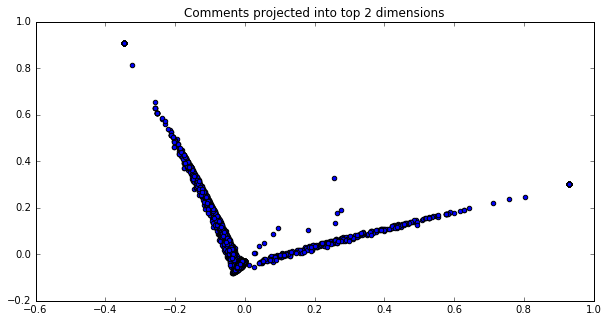

In [49]:
# rng = np.random.RandomState(1)
X = transformed_corpus[:,[0,1]]
plt.scatter(X[:, 0], X[:, 1])
plt.title('Comments projected into top 2 dimensions');

In [50]:
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

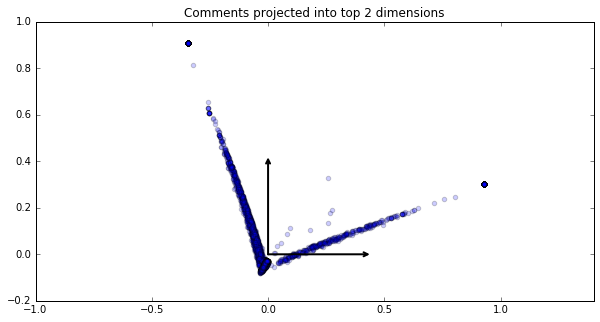

In [51]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');
plt.title('Comments projected into top 2 dimensions');

In [52]:
pca_tool.components_.shape

(200, 2598)

In [53]:
prin_comps = pd.DataFrame(pca_tool.components_)
prin_comps

,0,1,2,3,4,5,6,7,8,9,...,2588,2589,2590,2591,2592,2593,2594,2595,2596,2597
0,-0.006887,-0.000999,-0.001630,-0.001656,-0.000590,-0.000627,-0.004763,-0.004058,-0.002063,-0.002216,...,-0.000297,-0.000173,-0.000133,-0.000163,0.000282,-0.000187,-0.000177,-0.000173,-0.000092,-0.000192
1,-0.012387,-0.002272,-0.002734,-0.003747,-0.000909,-0.001298,-0.008756,-0.007112,-0.003239,-0.005019,...,-0.000696,-0.000421,-0.000420,-0.000343,-0.000341,-0.000093,-0.000563,-0.000339,-0.000235,-0.000536
2,0.074154,0.010666,0.018782,0.022070,0.003358,0.006941,0.044090,0.055211,0.008413,0.027463,...,0.002444,0.001233,0.001234,-0.000039,0.002477,0.001244,0.000088,0.001550,0.001252,-0.000256
3,-0.030499,0.002714,-0.003398,0.000932,-0.001316,0.001011,-0.011910,0.003895,-0.000855,-0.001716,...,0.003082,-0.000176,-0.000165,-0.000160,0.000597,-0.000646,-0.000214,-0.000025,-0.000377,0.000143
4,0.069611,-0.005311,0.009713,-0.003926,0.001230,0.002326,0.024697,-0.008277,-0.002049,0.005150,...,0.000259,0.000093,-0.000409,-0.000846,0.000300,0.000643,-0.000782,0.001138,0.000680,-0.000897
5,-0.151864,0.000678,-0.022020,-0.004161,-0.004148,-0.002086,-0.053444,-0.009546,-0.000144,-0.011663,...,-0.001436,-0.000375,-0.000219,0.000659,0.002124,-0.002715,0.000142,0.001138,-0.002150,0.001240
6,-0.019846,-0.000839,-0.001130,0.000837,0.002014,-0.001449,-0.012298,0.000058,-0.003475,-0.006820,...,-0.000431,0.000177,-0.000467,-0.000498,-0.000808,-0.000077,-0.000511,0.000364,0.000310,-0.000339
7,0.208819,0.006556,0.004479,0.003969,0.002100,0.001455,0.119690,0.010049,0.004189,0.014813,...,0.000282,0.001490,0.003426,0.002209,-0.003422,-0.002186,-0.000273,0.001776,-0.000630,0.003611
8,-0.318075,-0.009605,-0.014293,-0.003759,-0.005119,-0.006807,-0.202577,-0.027657,-0.002220,-0.037724,...,-0.001626,-0.000646,0.000137,0.000078,0.002952,0.002715,-0.001455,0.000034,0.000982,-0.001287
9,-0.055856,-0.001272,-0.002478,-0.003158,-0.000829,-0.001493,-0.043953,-0.001809,-0.004643,-0.007706,...,-0.000487,-0.000133,-0.002559,-0.001085,0.000634,0.000391,-0.000067,-0.000417,0.000164,-0.000709


In [54]:
for j in range(5):
    
    print("Component numer: " + str(j))

    component_j = prin_comps[j]

    order = component_j.map(lambda x : x).abs().sort_values(ascending = False)
    component_j[order.index]


    for i in range(10):
        idx = order.index[i]
        word = dictionary[idx]
        weight = str(component_j[idx])
        print(weight + " : " + word)
        
    print()

# sns.distplot(S);

Component numer: 0
0.387771517782 : reward
-0.318074857043 : miss
0.316164819048 : solut
0.236188572022 : thread
0.208819189946 : mechan
-0.193908547732 : basi
0.179508980813 : consum
-0.168872825222 : simpl
-0.153807856127 : system
-0.151864014281 : home

Component numer: 1
0.0417216067251 : veldspar
0.0333124514334 : massiv
-0.0318345887856 : allow
-0.0316368079079 : percentag
-0.0314807716084 : end
0.028094595561 : consum
-0.0274826290356 : work
-0.0266432664339 : harsh
0.0258183164791 : anchor
0.0256447203615 : think

Component numer: 2
-0.0357564736865 : return
-0.0253703668237 : ship
-0.0243185304265 : sale
0.0227962007969 : sort
-0.022030522182 : look
-0.0220197506967 : home
-0.0215284205093 : station
0.019660180352 : like
-0.0189779208248 : varieti
0.0187824402084 : enemi

Component numer: 3
0.0525386010269 : percentag
-0.0505993234461 : fewer
-0.0359957930738 : retriev
-0.0293237927134 : decreas
-0.0262391834208 : realiz
-0.0256968904003 : stupid
0.0249552136535 : featur
-0.02

These don't seem to be super interpretable. Try selecting representative comments.

In [55]:
transformed_corpus_df = pd.DataFrame(transformed_corpus)


# for the top component, select the indexes that are most associated with this comp and read them
for comp_num in range(100):
# comp_num = 0
    print("Component numer: " + str(comp_num))
    sorted_df = transformed_corpus_df.sort_values(by=comp_num,ascending=False)
    for top_comment_num in range(10):
    #     top_comment_num = 0
        top_comment_idx = sorted_df.index[top_comment_num]
        print(documents.loc[top_comment_idx][0])
        print()
# order = component_j.map(lambda x : x).abs().sort_values(ascending = False)

# component_j[order.index]

Component numer: 0
cosmetic

cosmetic only!

cosmetic only

cosmetic only

cosmetic only

cosmetic only

cosmetic only please

cosmetic only

cosmetic only

cosmetic only

Component numer: 1
supported

/supported

support

supported.

supported =)

supported

supported

supported.

support

supporting

Component numer: 2
+1i already allowed 3 of my accounts to run out last month. the only thing that has been keeping a lot of accounts active including mine is the training skills. this game keeps subscribers for one reason over all others. skill advancement and hope/belief in what the game may offer in the future. once that hope for "excellence" has gone, so will much of your player base. every new player signing onto these boards sees the mountain of discontent coming from old players over the last 9+ months and the ramifications aren't good. it is no longer just something probably effecting the older players but one that will bleed the numbers of new players into the system. that graph

signed.

signed

/signed

/signed

/signed

/signed

/signed

/signed

./signed \\ l'> ll llama~ || || '' ''

/signed

Component numer: 4
bad idea. no.

/signednice idea.

intriguing idea.

not a bad idea

bad idea

+1 for this idea

what is bad about my idea?

bad idea ccp.

i say no, what a bad idea.

awsome idea

Component numer: 5
awsome idea

bad idea

what is bad about my idea?

bad idea ccp.

/signednice idea.

intriguing idea.

not a bad idea

+1 for this idea

bad idea. no.

i say no, what a bad idea.

Component numer: 6
no i do not agree with it

agreed!<U+043D><U+043E> <U+043F><U+043E>!

agreed

agreed in full.

agree.

i agree.

agreed.

agreed.

agreed

agreed

Component numer: 7
vote no

im voting no!

vote no

nooooo noway no i vote no

i didn't vote for you, but i'll humor you anyway.[mandate] tiericidedon't you have a secretary?

another vote - please give us something new

voted

vote no

anoter vote - please give us something new

i vote no

Component numer: 8
^^ thi

all of my accounts say no.

no x2 for both my accounts

i like this idearebild drones!

galente power should be in drones & nosferatu not in hybrids.you have my drones and my onboard axe.

[expand='bla-bla-bla']when i read this topic on wiki i found the drones to be the main gallente weapon.may be it is the right time to re-balance the drones?i do not remember any changes affecting drones for the last 2-3 years except the nerf of some drone-ships through cutting the bandwidth or limiting the drone bay. nowadays we see a lot of changes in the world of new edem, the projectiles were re balanced, becoming a panacea for big fleet fights (arti abadon =_+), t3 ships were introduced (all glory the proteus as the "nerd ishtar"), there were the incursions, pi, 3d characters, wormholes, slippers, dramiel is still insane and now even considered "overpowered" and waiting for treatment in the form of nerf. the "not to be named" was named so and spawned tonns of hateposts (butthurt if you want) and 

remove them all together.

+1 to remove mt.

yes remove all microtransactions

removed!

+1remove from game?

supported,remove this cr*p!

yeah remove pirates plsall are nabs anyway

post removed.

no way. i still mean everyword but not a lot was ontopic so in the name of sanity i am removing it to a txt filestill high ****ed off though

+1 remove microtransactions.remove aurum currency.

Component numer: 29
indeed, thanks for that tidbit.

thanks!

no thanks

why, thank you.

first off thanks csm and trebdor for doing this!!! spillrag,123,83,1,2,3,8,27

lokiish 1, 2, 112, 146, 166, 49, 51thanks!~l

no not for me thanks

thanks salpun.

thanks.

why thank you...

Component numer: 30
i love freckled redheads <3

i love your pic!

love you longtime,13,32,34,68,77,78,124,166

love it

i love you...

for the love of god, yes!

love dan murcatto,47,71,51

ducky love,65,77,97,123,139,-119,-59

would love a little gallente love.

love it +1 support

Component numer: 31
drones need some seriou

we will see. in time :)

injury time,8,14,15,56,108,129,139,-32

ccp what have you been doing all this time?

oh yes, now that dnf is out too it's about time!

big time.

i have wanted this for a long time.

no, mt should be removed.this can and will get out of hand with time.

i propose each time you make a stupid proposal you get banned.

lol @ eris :d i like proposal. d3

something like this already proposed:

Component numer: 36
makes sense to me.

makes sense

makes sense.

makes sense.

this makes sense

makes sense.

makes sense.

makes sense

makes sense

makes sense. supported.

Component numer: 37
makes sense to me.

makes sense.

this makes sense

makes sense

makes sense

makes sense.

makes sense

makes sense.

makes sense.

+1it's a change that really makes sense.

Component numer: 38
^nice :-d

nice km.

nice.

very nice.

nice!

would be nice to have.

nice ideasupported

supported, would be nice

\o/ nice idea

nice idea

Component numer: 39
makes sense

makes sense

t

yes please! while they look great as detail in space, as icons they are just "blobs".

that's because when you alt-tab, it does a look at because of the keyup/down issue. :(

yes because you look like bruce

faction standings gain/loss needs to be balanced. currently, this system results in a general loss of standings with npc factions across the board, and no gain of npc standings except with one or two factions, by completing cosmo's, storyline, and data center missions, which also result in harsh penalties to other npc factions. i'd call it ~90% loss to 10% gain for npc faction standings. personally, i think this is rediculous, and see no reason why a player should suffer enemy of state standings with 1 or 2 factions, (not including pirate or npc variant factions), to have relatively good standings with another, losing the ability to enter various security levels of enemy faction space as their standings decrease, diplomacy skill or not.this should be changed in favor of increasing 

gone off, 119, 139, 149

it went poof, 15

can't have a roadmap if you already went off the cliff.

its not that....goes way beyond.

did i support this already..? if not - here goes.

i support this. space isn't ment to end it goes on and on and on.scorpionidae

... umm, what?this is a problem for game balance how?

i like the direction this is going.

no one see this as a problem?

don't we all have that problem ?

Component numer: 58
no no and noabsolutley no reason for a game with a monthly subscription to have micro transactions

war... huh... yeah!what is it good for?absolutely nothing!uhuh... uhuh...!war... huh... yeah!what it is good for?absolutely nothing!say it again y'allwar... huh... look out!what is it good for?absolutely nothing!listen to me - aah!

no micro transactions

no micro transactions

no **** micro transactions in eve!!

no! to micro-transactions

no to micro transactions

absolutely not

absolutly no

no, absolutely not - no!no

Component numer: 59
no for sure


i support this topic.

/support this topic

supporting own topic

i support this topic!

supporting my own topic

great trolls think alike. this is about a mechanics issue. not you should go somewhere else issue. if you have a point to make on topic please do, if not please gtfo.

maybe it's just me...but why did you support the topic then?

lol... just lol... nice topic

topic starts @ 2009.10.25just look t how mutch ccp have done so far ..

guys, please stay on topic, local changes is not part of this proposal.if you want to discuss local and other issues, please do it in your/appropriate topic.

Component numer: 71
wilber right,5,7,42,68,72

do it right the first time.

right, this topic is not going away.

a bit of a long read but very well thought out. +1

your half right.or full right? wouldnt that be left?oh god....

yes. long overdue.

long joseph,29,31,8,28,35,49,139,144,100,14

long overdue, really.

long as it is a one off.

because pirates never go after tankers, container 

i support this topic.

i support this topic!

supporting my own topic

supporting own topic

/support this topic

topic starts @ 2009.10.25just look t how mutch ccp have done so far ..

maybe it's just me...but why did you support the topic then?

lol... just lol... nice topic

i want to spin ships again.so that's why i fully support this topic.

i have only one thing to say...please visit your user settings to re-enable images.

Component numer: 80
its actually about 1mill sp per 17th day.

you didn't actually support.

this is actually a very fun idea.

this could actually work. cautious support.

actually a good idea.not supporting this would make me gay...er

i actually like the cq; but more options are good.

yes, he would. this is actually a pretty good idea and would make mining more intuitive.

i actually really like those ideas o_ofor the guns at least.

wow! this is actually a really good idea!but it only works if the loading of all the qc assets etc doesn't actually happen u

**** aurum and **** mt.

azrael aurum,85,71,68,35,47,29,123

no to aurum and no mt

who cares until i can spend my isk to buy aurum

pvp should cost aurum

don't care about aurum don't care how much i have.

get rid of the gates! :)

acrinimiril gate 14,34,49,91,41,70,90

not going to get aurum, no need for a aurum balance. get this stuff out of my sight

i don't need to see the amount of aurum i currently have right below the amount of isk i have on the wallet tab. i also love how you think by putting it in turquoise to pop off the screen will make me think i need to get some aurum because the balance is zero. nice try.under the settings tab there should be an option to not display the amount of aurum you have. also put the isk amount back on the left.

Component numer: 91
does this mean sto was on its last legs before it had even come out :-poh wait, it was :-p

a song of fire and.. wait what?i'll be there

sooo, we are waiting :)

+1... wait.. +100500!

in hindsight, i wish a waited

These seem to be more interpretable. The components seem to make more sense, although in some cases it is clear they are leaning heavily on certain words. 

Now let's go back to the network to see what emerges.


Let's do a quick regression to see which components align with negativity

In [56]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
X = transformed_corpus
y = list(documents['negative'])

results = sm.OLS(y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     8.604
Date:                Wed, 07 Nov 2018   Prob (F-statistic):          1.37e-228
Time:                        20:00:35   Log-Likelihood:                 4755.1
No. Observations:               21515   AIC:                            -9110.
Df Residuals:                   21315   BIC:                            -7515.
Df Model:                         200                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0200      0.009     -2.192      0.0

//anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Now let's go back to the network to see what emerges.

### Clustering
#### Hierarchical Clustering
PCA already reduced the dimensionality, so Hierarchical Clustering should not be too too slow.


### Lexical Networks
Plan:
1. Add bigrams and trigrams to the dictionary (can do later)
    2. Then filter it again for low-frequency terms or super high-freq terms (>50%)
3. Create an M x M matrix, where M is the number of terms in the dictionary
4. O(N) to fill out the matrix. Iterate through the list of comments (That have been reduced to bag of words/terms). In each post, for each pair of words, increment the value in the matrix, weighted by TFIDF (the product of the two terms' value).
5. Once done, make the matrix sparser by thresholding values below the 50% (median) value.
6. Visualize the matrix (probably get a hairball). Can tune the thresholding until getting cleaner separation.
7. Run community detection algo to get 'themes'

In [57]:
# don't even need to create a matrix (too much space). Just create a dictionary (link_list)
idx = 0
link_weights = {}
link_text = {}
for post in corpus_tfidf:
    L = len(post)
    # cycle thru each word (i) in the post and the subsequent words (j).
    # if this pair of words is unseen, add it to the dict of weights. Otherwise, add it to the existing entry
    for i in range(L):
        for j in range(i,L):
            if (i<j):
                weight = post[i][1]*post[j][1]
#                 print(str(i) + " , " + str(j) + ": " + str(weight))
                
                the_key = (dictionary[post[i][0]],dictionary[post[j][0]])
                if the_key in link_weights:
                    link_weights[the_key] = link_weights[the_key]+ weight
#                     link_text[the_key].append(documents.loc[idx][0])
                else:
                    link_weights[the_key] = weight
                    link_text[the_key] = [documents.loc[idx][0]]
    if idx % 500 == 0:
        print(str(idx)+" posts   ||   date-time = "+str(datetime.datetime.now()))
    idx = idx + 1
print('Done.')
                    

0 posts   ||   date-time = 2018-11-07 20:00:36.533492
500 posts   ||   date-time = 2018-11-07 20:02:36.954994
1000 posts   ||   date-time = 2018-11-07 20:03:11.317772
1500 posts   ||   date-time = 2018-11-07 20:03:41.933469
2000 posts   ||   date-time = 2018-11-07 20:04:09.801773
2500 posts   ||   date-time = 2018-11-07 20:04:43.843643
3000 posts   ||   date-time = 2018-11-07 20:05:06.078492
3500 posts   ||   date-time = 2018-11-07 20:05:26.155901
4000 posts   ||   date-time = 2018-11-07 20:05:48.073977
4500 posts   ||   date-time = 2018-11-07 20:06:10.020952
5000 posts   ||   date-time = 2018-11-07 20:06:27.598414
5500 posts   ||   date-time = 2018-11-07 20:06:55.230080
6000 posts   ||   date-time = 2018-11-07 20:07:20.051415
6500 posts   ||   date-time = 2018-11-07 20:07:37.542665
7000 posts   ||   date-time = 2018-11-07 20:08:03.735463
7500 posts   ||   date-time = 2018-11-07 20:08:31.988005
8000 posts   ||   date-time = 2018-11-07 20:08:51.539087
8500 posts   ||   date-time = 2018-

In [58]:

# link_weights.keys()
# link_weights.values()
k = list(link_weights.keys())
v = list(link_weights.values())
d = {'links': k, 'weights': v}

link_weights_df = pd.DataFrame(d)
link_weights_df.sort_values(by='weights',ascending=False)


,links,weights
1473629,"(item, vaniti)",16.370379
861830,"(idea, good)",15.836441
745007,"(game, play)",15.403066
272310,"(idea, support)",13.402319
97461,"(like, idea)",12.895289
724473,"(game, player)",12.318373
669371,"(skill, train)",11.446935
108174,"(micro, transact)",11.153592
382246,"(make, sens)",10.653246
1119776,"(game, like)",9.454287


In [59]:
len(link_weights_df)

1596318

The "strongest" link is (item, vaniti)	

Visualize the distribution:

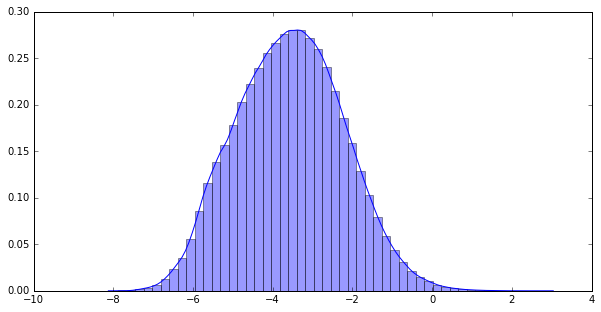

In [60]:
import seaborn as sns
#Log Scale
sns.distplot(np.log(v));


Select only the links with strong weights

In [61]:
order = link_weights_df.sort_values(by='weights',ascending=False).index

#### How many links? top 100

In [98]:
# top_pct = 0.10
# top_N = top_pct*len(order)
top_N = 100# just pick 100 arbitrarily
top_links = order[:top_N]
top_link_weights_df = link_weights_df.loc[top_links]
# top_link_weights_df

In [99]:
# need to split the links into separate columns after all

top_link_weights_df[['node_i','node_j']] = top_link_weights_df['links'].apply(pd.Series)
top_link_weights_df

,links,weights,node_i,node_j
1473629,"(item, vaniti)",16.370379,item,vaniti
861830,"(idea, good)",15.836441,idea,good
745007,"(game, play)",15.403066,game,play
272310,"(idea, support)",13.402319,idea,support
97461,"(like, idea)",12.895289,like,idea
724473,"(game, player)",12.318373,game,player
669371,"(skill, train)",11.446935,skill,train
108174,"(micro, transact)",11.153592,micro,transact
382246,"(make, sens)",10.653246,make,sens
1119776,"(game, like)",9.454287,game,like


#### Creating a Graph

In [100]:
import networkx as nx

In [101]:
# Creating a Graph 
G=nx.from_pandas_dataframe(top_link_weights_df, 'node_i', 'node_j', ['weights'])

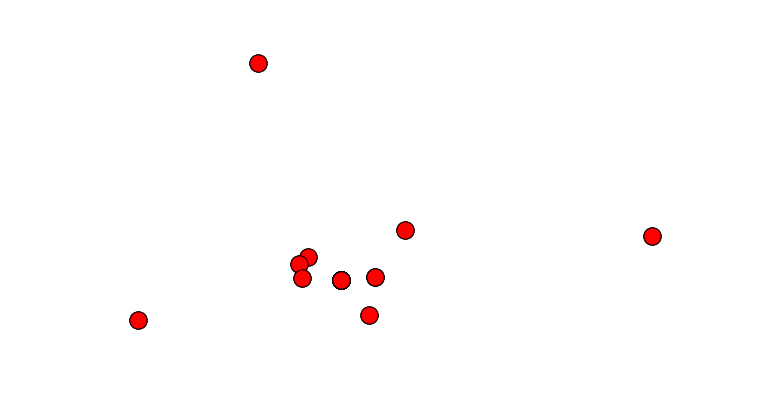

In [102]:
nx.draw_spectral(G)

Spectral representation looks like it structures the nodes well. Maybe try spectral clustering on the network to find the key themes.

In [103]:
from sklearn.cluster import SpectralClustering
from sklearn import metrics

n_clusters = 8

# Get adjacency-matrix as numpy-array
adj_mat = nx.to_numpy_matrix(G,weight='weights')

# Cluster
sc = SpectralClustering(n_clusters, affinity='precomputed', n_init=100)
sc.fit(adj_mat)


//anaconda/lib/python3.5/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


SpectralClustering(affinity='precomputed', assign_labels='kmeans', coef0=1,
          degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
          kernel_params=None, n_clusters=8, n_init=100, n_jobs=1,
          n_neighbors=10, random_state=None)

In [104]:
adj_mat.max()

16.370379266809486

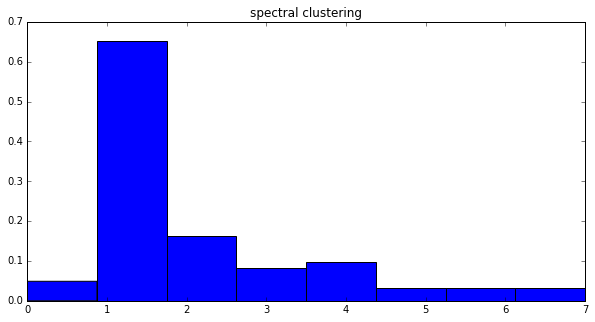

In [105]:
plt.hist(sc.labels_,normed=True,bins=n_clusters); plt.title('spectral clustering')

In [106]:
# Try another clustering algo
# from networkx.algorithms.community import greedy_modularity_communities
# import community

In [107]:
#first compute the best partition
# partition = community.best_partition(G)

In [108]:
pagerank = nx.eigenvector_centrality_numpy(G)
# k_pr = list(pagerank.keys())
# v_pr = list(pagerank.values())
# df_pr = pd.DataFrame({'term' : k_pr, 'eigen_centrality':v_pr})
# pagerank

In [109]:
df = pd.DataFrame({'term' : G.nodes(), 'cluster' : sc.labels_})
df['eigen_centrality'] = 0
for idx in df.index:
    term = df.loc[idx,'term']
    df.loc[idx,'eigen_centrality'] = pagerank[term]
df.sort_values('eigen_centrality',ascending=False)

,cluster,term,eigen_centrality
36,7,game,3.914155e-01
55,7,ship,3.674687e-01
59,2,like,3.618697e-01
4,2,player,3.136632e-01
52,2,want,2.893593e-01
6,2,peopl,2.892006e-01
64,2,time,2.582789e-01
20,2,think,2.228731e-01
54,2,play,1.980393e-01
41,1,chang,1.895254e-01


In [110]:
# Create-subgraphs and visualize each one.
top_link_weights_df[['node_i','node_j']]

# df.sort_values(by='cluster')

sub_community = {}
for clust_id in range(n_clusters):
    community_nodes = list(df[df['cluster']==clust_id]['term'])
    sub_community[clust_id] = top_link_weights_df[top_link_weights_df['node_i'].isin(community_nodes)]
    print(df[df['cluster']==clust_id].sort_values('eigen_centrality',ascending=False))
    print()

# for each term, get the top weighted link
# for each link, get a comment with that link in it (this might take more time, should do ahead of time)

    cluster     term  eigen_centrality
53        0     idea          0.128235
26        0  support          0.038010
67        0   thread          0.004642

    cluster     term  eigen_centrality
41        1    chang      1.895254e-01
22        1     need      1.646535e-01
14        1    thing      9.065894e-02
9         1  charact      6.312166e-02
49        1    point      6.312166e-02
25        1     good      5.985175e-02
39        1     plex      5.849993e-02
50        1     real      4.710741e-02
60        1    money      4.710741e-02
32        1  gallent      4.487538e-02
48        1    damag      4.422539e-02
28        1    drone      4.422539e-02
34        1   balanc      4.422539e-02
1         1    fleet      4.422539e-02
16        1     spin      4.422539e-02
44        1    bonus      4.422539e-02
8         1      fit      4.422539e-02
57        1     rang      4.422539e-02
27        1     look      4.355153e-02
15        1   option      3.482480e-02
24        1     love    

//anaconda/lib/python3.5/site-packages/matplotlib/collections.py:806: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


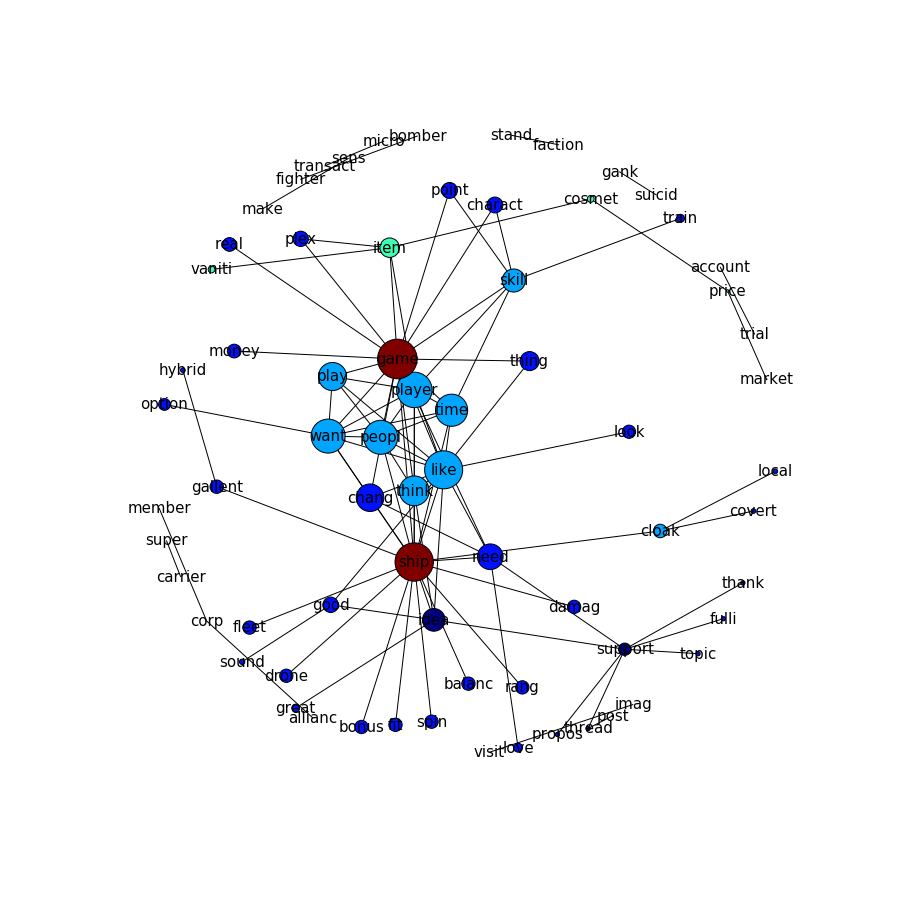

In [119]:
plt.figure(3,figsize=(12,12)) 
nx.draw(G,with_labels=True,node_size=4000*df['eigen_centrality'],node_color=sc.labels_,font_size=15)

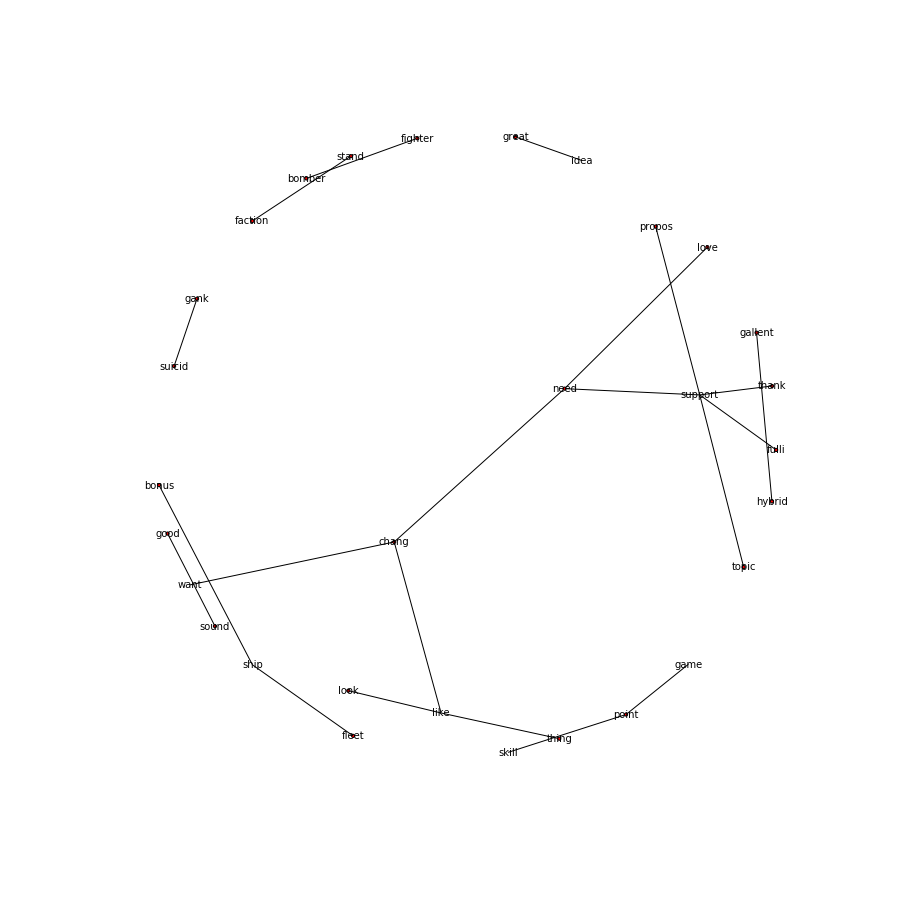

In [111]:
clust_id = 1
sub_G=nx.from_pandas_dataframe(sub_community[clust_id], 'node_i', 'node_j', ['weights'])
sub_community[clust_id]
community_nodes = list(df[df['cluster']==clust_id]['term'])
in_commnity =  pd.Series(sub_G.nodes()).isin(community_nodes)

df2 = pd.DataFrame({'term' : sub_G.nodes()})
df2['eigen_centrality'] = 0
for idx in df2.index:
    term = df2.loc[idx,'term']
    df2.loc[idx,'eigen_centrality'] = pagerank[term]
# df2.sort_values('eigen_centrality',ascending=False)
# larger figure size
plt.figure(3,figsize=(12,12)) 
nx.draw(sub_G,with_labels=True,node_size=10*in_commnity,node_color=in_commnity*2,cmap=plt.get_cmap('rainbow'),font_size=10)
plt.show()

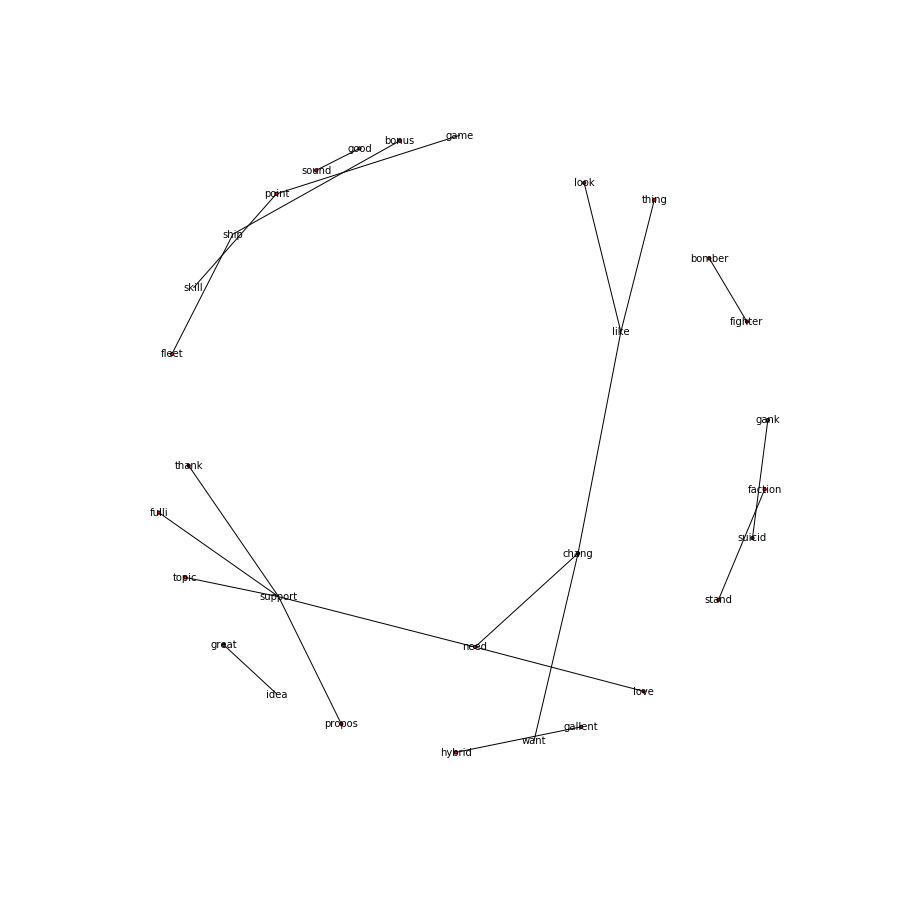

In [112]:
# larger figure size
plt.figure(3,figsize=(12,12)) 
nx.draw(sub_G,with_labels=True,node_size=10*in_commnity,node_color=in_commnity*2,cmap=plt.get_cmap('rainbow'),font_size=10)
plt.show()


In [113]:
clust_id

1

#### How many links? top 1000

In [122]:
# top_pct = 0.10
# top_N = top_pct*len(order)
top_N = 1000# just pick 1000 arbitrarily
top_links = order[:top_N]
top_link_weights_df = link_weights_df.loc[top_links]
# top_link_weights_df

In [123]:
# need to split the links into separate columns after all

top_link_weights_df[['node_i','node_j']] = top_link_weights_df['links'].apply(pd.Series)
top_link_weights_df

,links,weights,node_i,node_j
1473629,"(item, vaniti)",16.370379,item,vaniti
861830,"(idea, good)",15.836441,idea,good
745007,"(game, play)",15.403066,game,play
272310,"(idea, support)",13.402319,idea,support
97461,"(like, idea)",12.895289,like,idea
724473,"(game, player)",12.318373,game,player
669371,"(skill, train)",11.446935,skill,train
108174,"(micro, transact)",11.153592,micro,transact
382246,"(make, sens)",10.653246,make,sens
1119776,"(game, like)",9.454287,game,like


#### Creating a Graph

In [124]:
import networkx as nx

In [125]:
# Creating a Graph 
G=nx.from_pandas_dataframe(top_link_weights_df, 'node_i', 'node_j', ['weights'])

In [127]:
# nx.draw_spectral(G)

Spectral representation looks like it structures the nodes well. Maybe try spectral clustering on the network to find the key themes.

In [164]:
from sklearn.cluster import SpectralClustering
from sklearn import metrics

n_clusters = 50

# Get adjacency-matrix as numpy-array
adj_mat = nx.to_numpy_matrix(G,weight='weights')

# Cluster
sc = SpectralClustering(n_clusters, affinity='precomputed', n_init=100)
sc.fit(adj_mat)


//anaconda/lib/python3.5/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


SpectralClustering(affinity='precomputed', assign_labels='kmeans', coef0=1,
          degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
          kernel_params=None, n_clusters=50, n_init=100, n_jobs=1,
          n_neighbors=10, random_state=None)

In [165]:
adj_mat.max()

16.370379266809486

In [166]:
# plt.hist(sc.labels_,normed=True,bins=n_clusters); plt.title('spectral clustering')

In [167]:
# Try another clustering algo
# from networkx.algorithms.community import greedy_modularity_communities
# import community

In [168]:
#first compute the best partition
# partition = community.best_partition(G)

In [169]:
pagerank = nx.eigenvector_centrality_numpy(G)
# k_pr = list(pagerank.keys())
# v_pr = list(pagerank.values())
# df_pr = pd.DataFrame({'term' : k_pr, 'eigen_centrality':v_pr})
# pagerank

In [170]:
df = pd.DataFrame({'term' : G.nodes(), 'cluster' : sc.labels_})
df['eigen_centrality'] = 0
for idx in df.index:
    term = df.loc[idx,'term']
    df.loc[idx,'eigen_centrality'] = pagerank[term]
df.sort_values('eigen_centrality',ascending=False)

,cluster,term,eigen_centrality
185,3,game,2.711540e-01
201,2,ship,2.691124e-01
70,6,like,2.565368e-01
153,20,player,2.434211e-01
4,33,peopl,2.295991e-01
126,22,time,2.163185e-01
20,6,think,2.140264e-01
189,22,want,2.127060e-01
243,40,need,2.017454e-01
281,24,chang,1.701307e-01


In [171]:
# Create-subgraphs and visualize each one.
top_link_weights_df[['node_i','node_j']]

# df.sort_values(by='cluster')

sub_community = {}
for clust_id in range(n_clusters):
    community_nodes = list(df[df['cluster']==clust_id]['term'])
    sub_community[clust_id] = top_link_weights_df[top_link_weights_df['node_i'].isin(community_nodes)]
    print(df[df['cluster']==clust_id].sort_values('eigen_centrality',ascending=False))
    print()

# for each term, get the top weighted link
# for each link, get a comment with that link in it (this might take more time, should do ahead of time)

     cluster     term  eigen_centrality
217        0  gallent          0.030283
161        0   hybrid          0.015311

     cluster    term  eigen_centrality
130        1      go          0.115213
263        1    work          0.107828
249        1    look          0.107136
205        1    come          0.100447
166        1  actual          0.097941
282        1     abl          0.089121
111        1  reason          0.083570
15         1     say          0.082610
155        1    mean          0.079232
186        1    year          0.078375
93         1  better          0.073956
90         1   right          0.070629
135        1    long          0.070028
78         1  propos          0.063377
222        1   allow          0.059327
50         1   space          0.056612
91         1   start          0.056374
26         1    dont          0.053404
64         1   month          0.048664
162        1    agre          0.047205
302        1   level          0.027015
8          1   sound 

45       41  sure          0.037928

     cluster    term  eigen_centrality
181       42    high          0.084778
79        42    risk          0.016798
289       42  reward          0.000629

     cluster    term  eigen_centrality
230       43  turret          0.010523
101       43    icon          0.000394

     cluster  term  eigen_centrality
221       44   fit          0.011315
138       44  save          0.000424

     cluster     term  eigen_centrality
48        45  fighter          0.001451
195       45   bomber          0.000054

     cluster     term  eigen_centrality
169       46     nerf          0.023156
199       46     buff          0.019645
19        46   frigat          0.010539
237       46  dramiel          0.001262

     cluster     term  eigen_centrality
55        47  quarter     -1.816250e-18
148       47  captain     -6.347022e-18

     cluster    term  eigen_centrality
242       48   black          0.010229
180       48  covert          0.003898

     cluster   

//anaconda/lib/python3.5/site-packages/matplotlib/collections.py:806: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


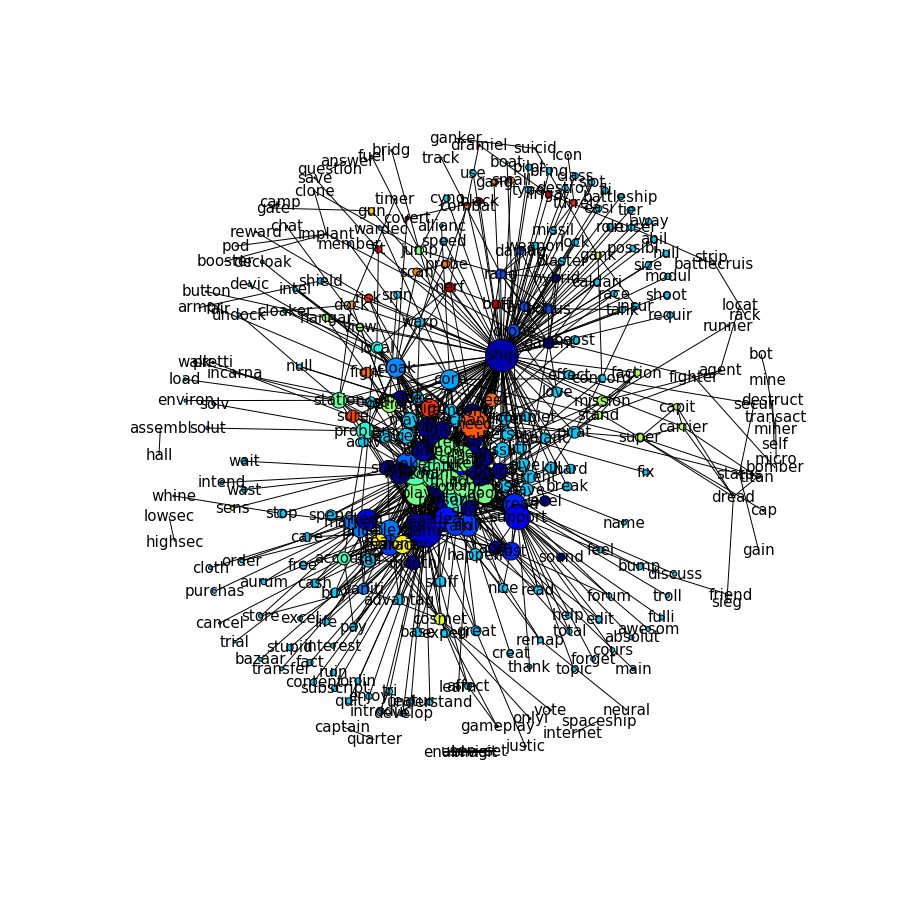

In [172]:
plt.figure(3,figsize=(12,12)) 
nx.draw(G,with_labels=True,node_size=4000*df['eigen_centrality'],node_color=sc.labels_,font_size=15)

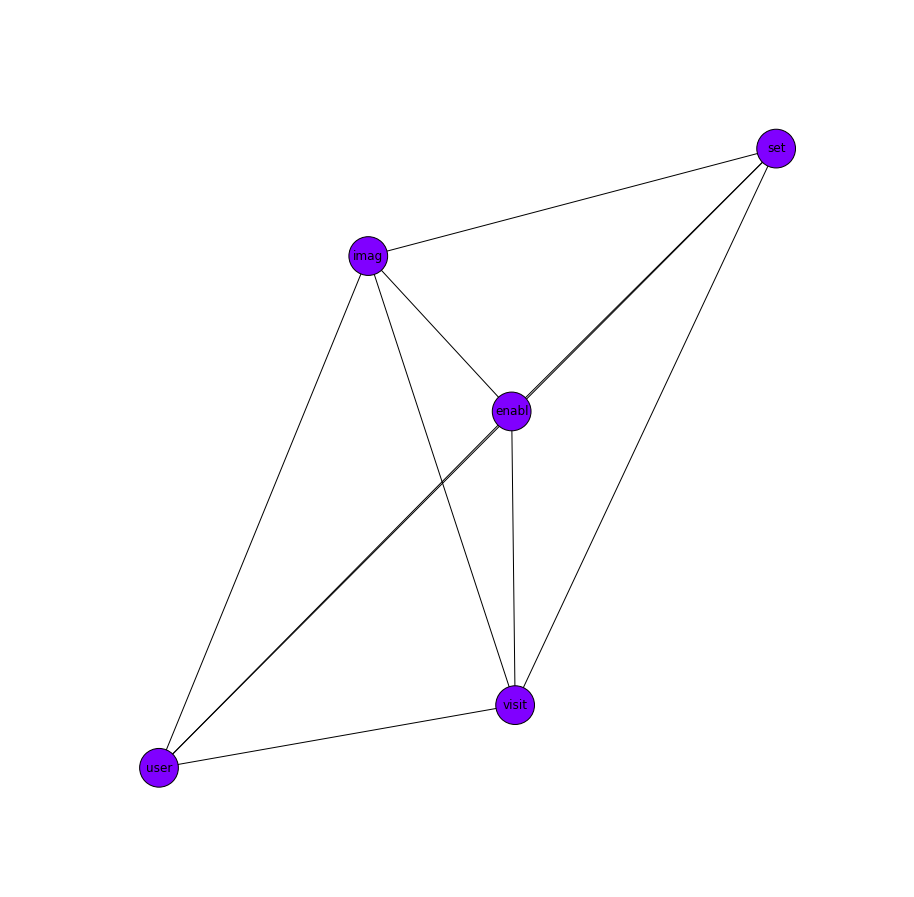

In [182]:
clust_id = 17
sub_G=nx.from_pandas_dataframe(sub_community[clust_id], 'node_i', 'node_j', ['weights'])
sub_community[clust_id]
community_nodes = list(df[df['cluster']==clust_id]['term'])
in_commnity =  pd.Series(sub_G.nodes()).isin(community_nodes)

df2 = pd.DataFrame({'term' : sub_G.nodes()})
df2['eigen_centrality'] = 0
for idx in df2.index:
    term = df2.loc[idx,'term']
    df2.loc[idx,'eigen_centrality'] = pagerank[term]
# df2.sort_values('eigen_centrality',ascending=False)
# larger figure size
plt.figure(3,figsize=(12,12)) 
nx.draw(sub_G,with_labels=True,node_size=1500*in_commnity,node_color=in_commnity*2,cmap=plt.get_cmap('rainbow'),font_size=12)
plt.show()

In [153]:
# get sub-clusters from cluster 0
clust_id = 0
sub_G=nx.from_pandas_dataframe(sub_community[clust_id], 'node_i', 'node_j', ['weights'])

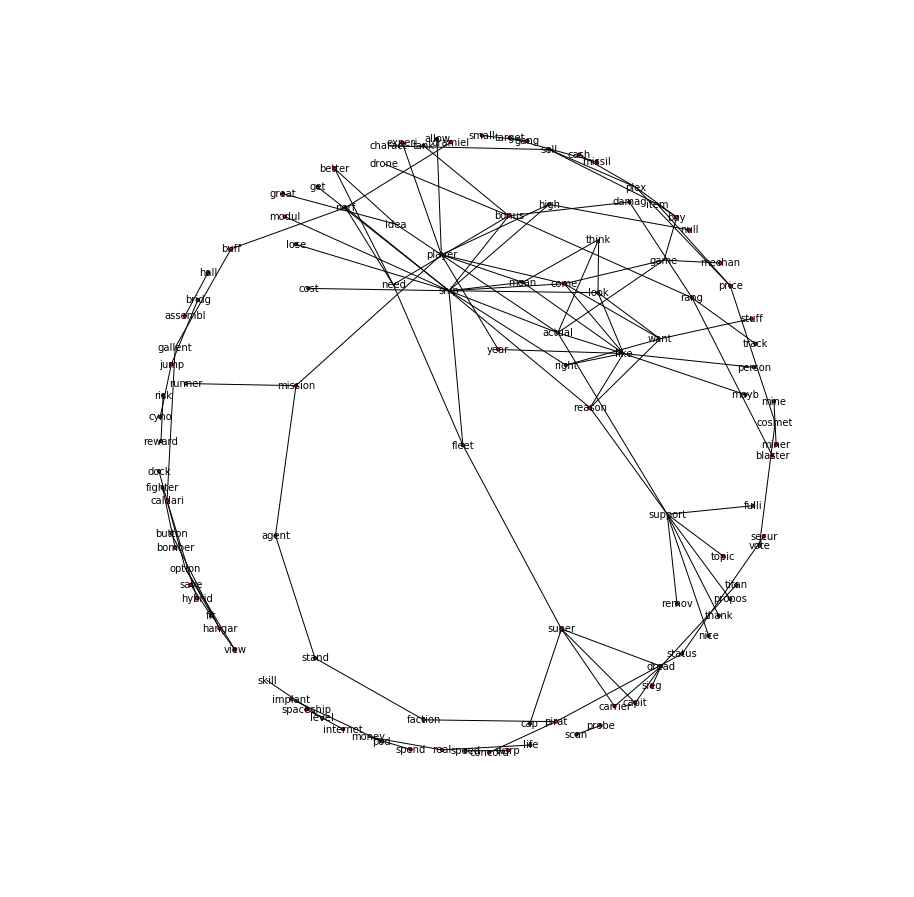

In [93]:
# larger figure size
plt.figure(3,figsize=(12,12)) 
nx.draw(sub_G,with_labels=True,node_size=10*in_commnity,node_color=in_commnity*2,cmap=plt.get_cmap('rainbow'),font_size=10)
plt.show()


In [76]:
clust_id

0

//anaconda/lib/python3.5/site-packages/matplotlib/collections.py:806: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


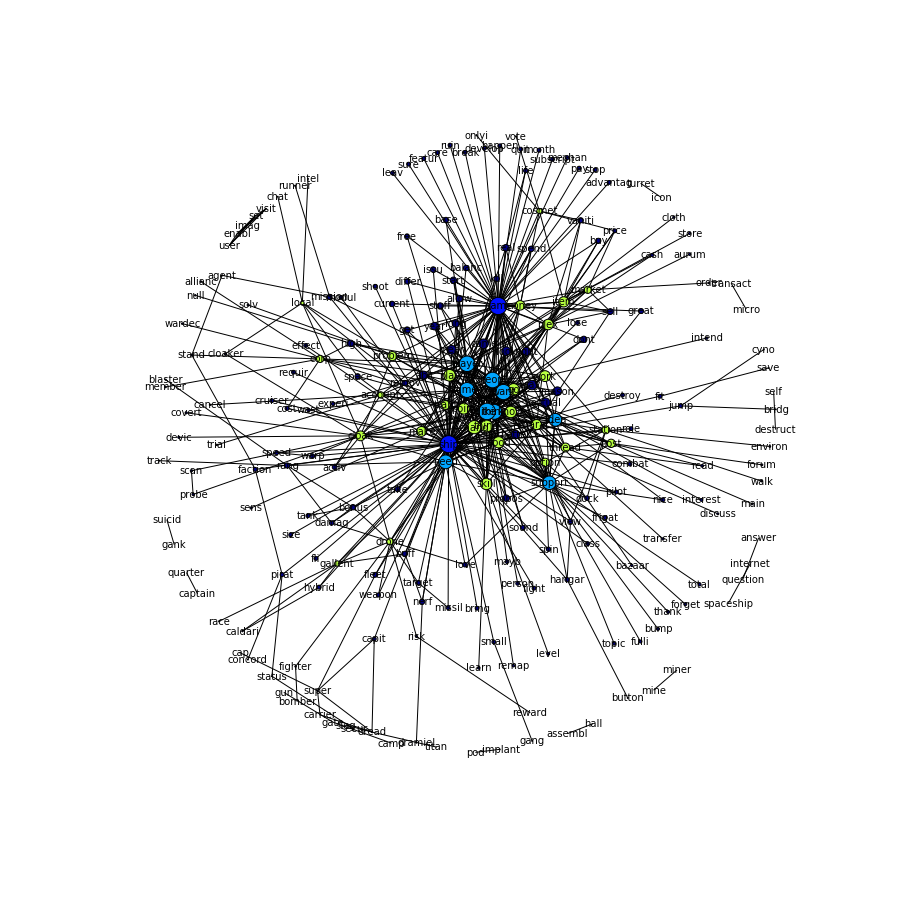

In [97]:
plt.figure(3,figsize=(12,12)) 
nx.draw(G,with_labels=True,node_size=1000*df['eigen_centrality'],node_color=sc.labels_,font_size=10)

#### How many links? top 600

In [62]:
# top_pct = 0.10
# top_N = top_pct*len(order)
top_N = 600# just pick 1000 arbitrarily
top_links = order[:top_N]
top_link_weights_df = link_weights_df.loc[top_links]
# top_link_weights_df

In [63]:
# need to split the links into separate columns after all

top_link_weights_df[['node_i','node_j']] = top_link_weights_df['links'].apply(pd.Series)
top_link_weights_df

,links,weights,node_i,node_j
1473629,"(item, vaniti)",16.370379,item,vaniti
861830,"(idea, good)",15.836441,idea,good
745007,"(game, play)",15.403066,game,play
272310,"(idea, support)",13.402319,idea,support
97461,"(like, idea)",12.895289,like,idea
724473,"(game, player)",12.318373,game,player
669371,"(skill, train)",11.446935,skill,train
108174,"(micro, transact)",11.153592,micro,transact
382246,"(make, sens)",10.653246,make,sens
1119776,"(game, like)",9.454287,game,like


#### Creating a Graph

In [64]:
import networkx as nx

In [65]:
# Creating a Graph 
G=nx.from_pandas_dataframe(top_link_weights_df, 'node_i', 'node_j', ['weights'])

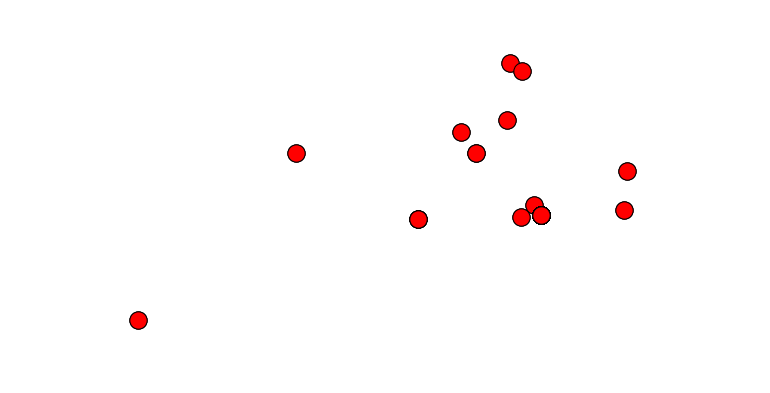

In [66]:
nx.draw_spectral(G)

Spectral representation looks like it structures the nodes well. Maybe try spectral clustering on the network to find the key themes.

In [67]:
from sklearn.cluster import SpectralClustering
from sklearn import metrics

n_clusters = 8

# Get adjacency-matrix as numpy-array
adj_mat = nx.to_numpy_matrix(G,weight='weights')

# Cluster
sc = SpectralClustering(n_clusters, affinity='precomputed', n_init=100)
sc.fit(adj_mat)


//anaconda/lib/python3.5/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


SpectralClustering(affinity='precomputed', assign_labels='kmeans', coef0=1,
          degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
          kernel_params=None, n_clusters=8, n_init=100, n_jobs=1,
          n_neighbors=10, random_state=None)

In [68]:
adj_mat.max()

16.370379266809486

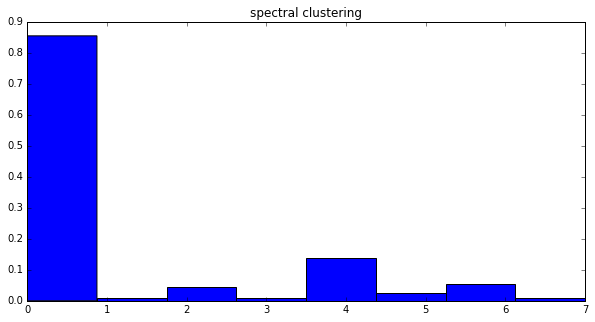

In [69]:
plt.hist(sc.labels_,normed=True,bins=n_clusters); plt.title('spectral clustering')

In [70]:
# Try another clustering algo
# from networkx.algorithms.community import greedy_modularity_communities
# import community

In [71]:
#first compute the best partition
# partition = community.best_partition(G)

In [72]:
pagerank = nx.eigenvector_centrality_numpy(G)
# k_pr = list(pagerank.keys())
# v_pr = list(pagerank.values())
# df_pr = pd.DataFrame({'term' : k_pr, 'eigen_centrality':v_pr})
# pagerank

In [73]:
df = pd.DataFrame({'term' : G.nodes(), 'cluster' : sc.labels_})
df['eigen_centrality'] = 0
for idx in df.index:
    term = df.loc[idx,'term']
    df.loc[idx,'eigen_centrality'] = pagerank[term]
df.sort_values('eigen_centrality',ascending=False)

,cluster,term,eigen_centrality
137,1,game,2.986072e-01
152,1,ship,2.938412e-01
51,2,like,2.744833e-01
2,2,peopl,2.446273e-01
114,2,player,2.413995e-01
140,2,want,2.349586e-01
95,2,time,2.242177e-01
13,2,think,2.239254e-01
185,2,need,1.907627e-01
77,2,support,1.842057e-01


In [74]:
# Create-subgraphs and visualize each one.
top_link_weights_df[['node_i','node_j']]

# df.sort_values(by='cluster')

sub_community = {}
for clust_id in range(n_clusters):
    community_nodes = list(df[df['cluster']==clust_id]['term'])
    sub_community[clust_id] = top_link_weights_df[top_link_weights_df['node_i'].isin(community_nodes)]
    print(df[df['cluster']==clust_id].sort_values('eigen_centrality',ascending=False))
    print()

# for each term, get the top weighted link
# for each link, get a comment with that link in it (this might take more time, should do ahead of time)

     cluster       term  eigen_centrality
10         0        say      8.980231e-02
155        0       come      8.919464e-02
123        0     actual      8.282952e-02
116        0       mean      7.761542e-02
189        0       look      7.729839e-02
84         0     reason      7.534336e-02
69         0     better      7.111152e-02
214        0        abl      7.087158e-02
66         0      right      6.527204e-02
138        0       year      5.779804e-02
102        0       long      5.207879e-02
208        0       real      4.389360e-02
57         0     propos      4.224559e-02
169        0      allow      4.104262e-02
133        0       high      4.103820e-02
117        0        get      4.019692e-02
67         0      start      4.008981e-02
219        0      stuff      3.977279e-02
18         0       dont      3.977279e-02
111        0       sell      3.292414e-02
143        0      spend      3.017738e-02
63         0    current      2.916076e-02
207        0       issu      2.916

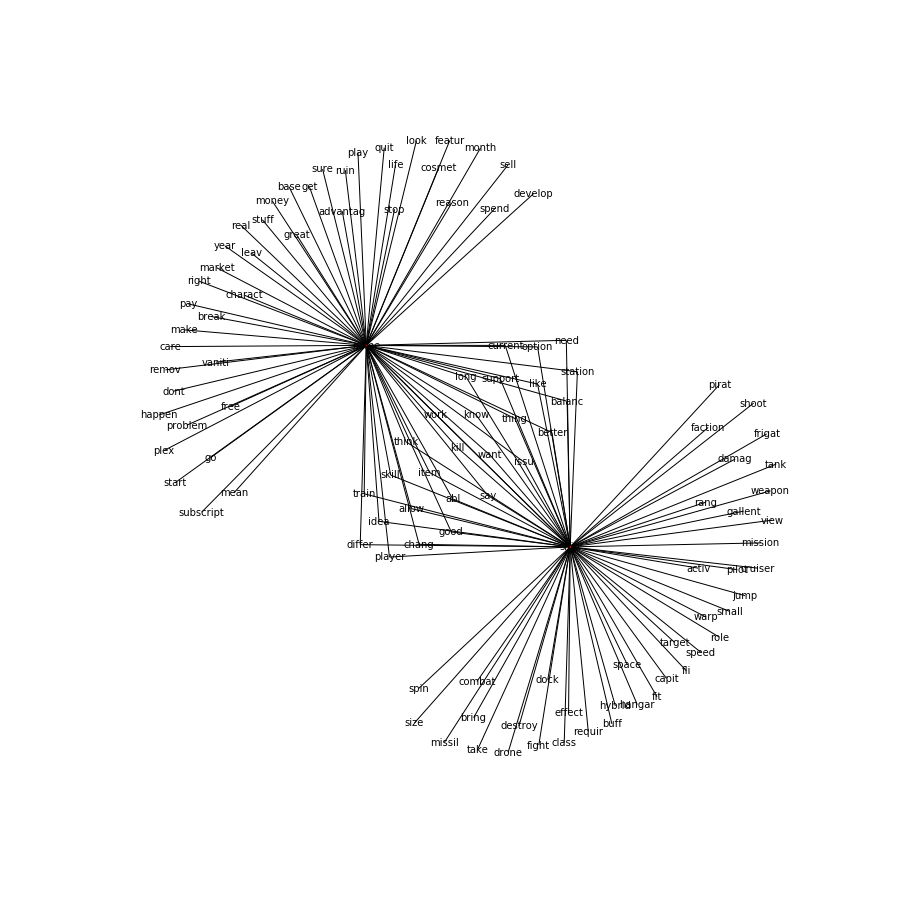

In [95]:
clust_id = 1
sub_G=nx.from_pandas_dataframe(sub_community[clust_id], 'node_i', 'node_j', ['weights'])
sub_community[clust_id]
community_nodes = list(df[df['cluster']==clust_id]['term'])
in_commnity =  pd.Series(sub_G.nodes()).isin(community_nodes)

df2 = pd.DataFrame({'term' : sub_G.nodes()})
df2['eigen_centrality'] = 0
for idx in df2.index:
    term = df2.loc[idx,'term']
    df2.loc[idx,'eigen_centrality'] = pagerank[term]
# df2.sort_values('eigen_centrality',ascending=False)
# larger figure size
plt.figure(3,figsize=(12,12)) 
nx.draw(sub_G,with_labels=True,node_size=10*in_commnity,node_color=in_commnity*2,cmap=plt.get_cmap('rainbow'),font_size=10)
plt.show()

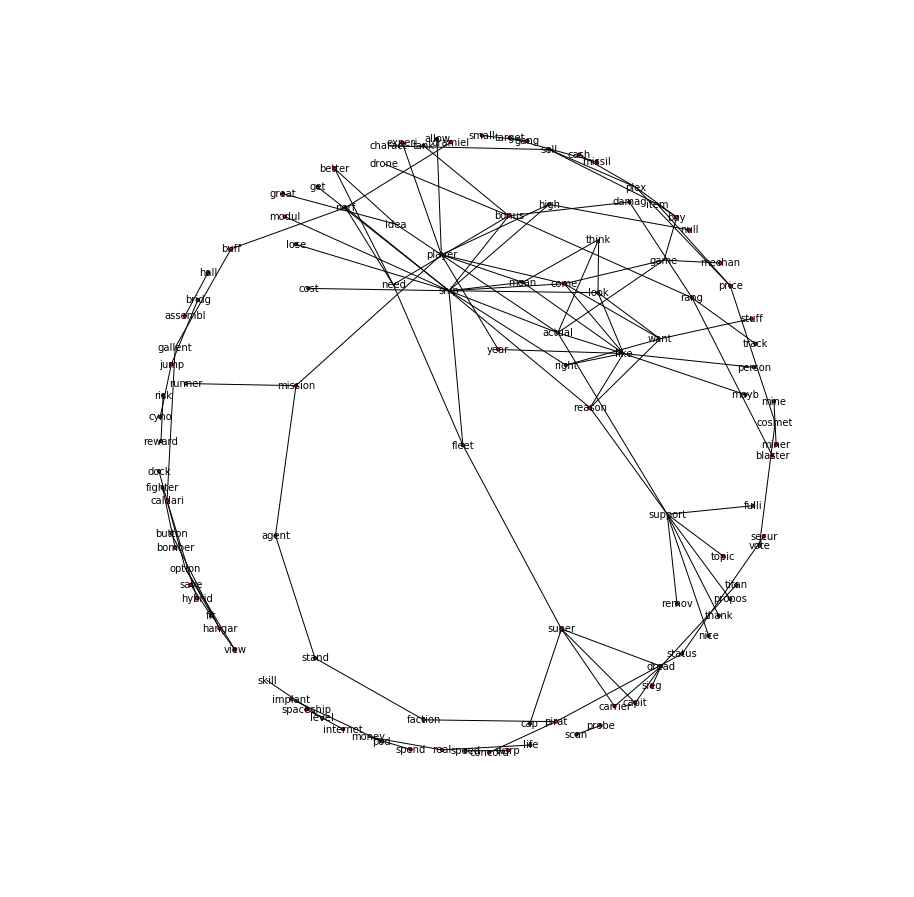

In [93]:
# larger figure size
plt.figure(3,figsize=(12,12)) 
nx.draw(sub_G,with_labels=True,node_size=10*in_commnity,node_color=in_commnity*2,cmap=plt.get_cmap('rainbow'),font_size=10)
plt.show()


In [76]:
clust_id

0

//anaconda/lib/python3.5/site-packages/matplotlib/collections.py:806: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


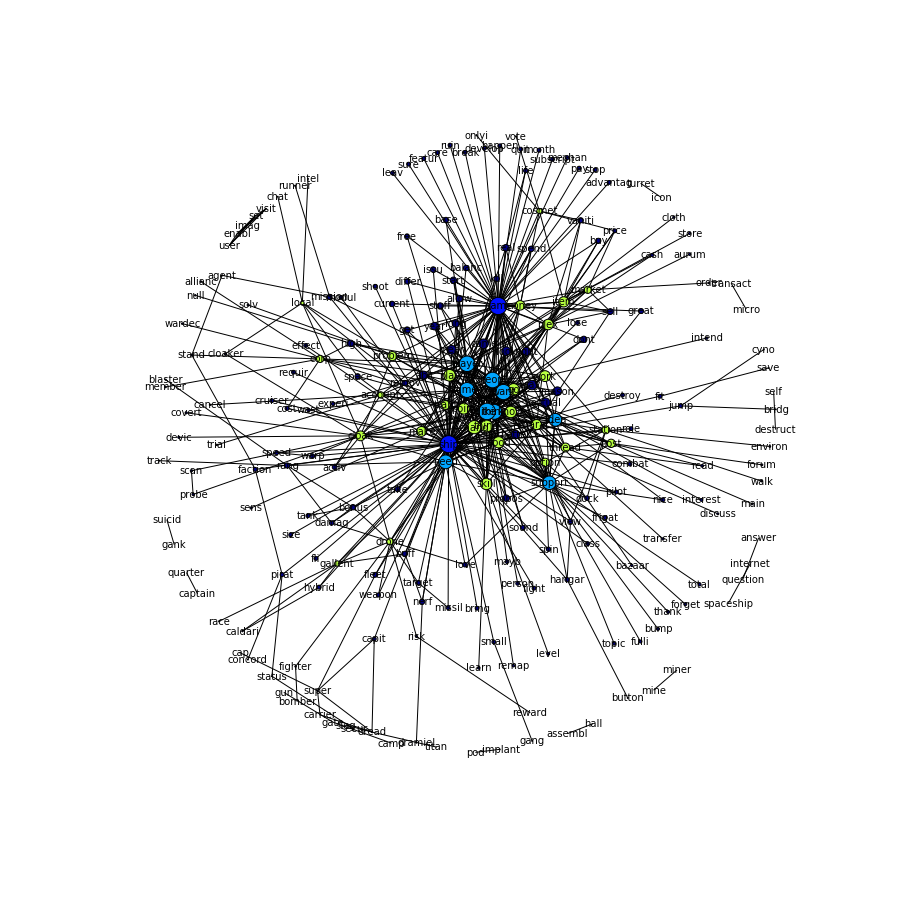

In [97]:
plt.figure(3,figsize=(12,12)) 
nx.draw(G,with_labels=True,node_size=1000*df['eigen_centrality'],node_color=sc.labels_,font_size=10)

//anaconda/lib/python3.5/site-packages/matplotlib/collections.py:806: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


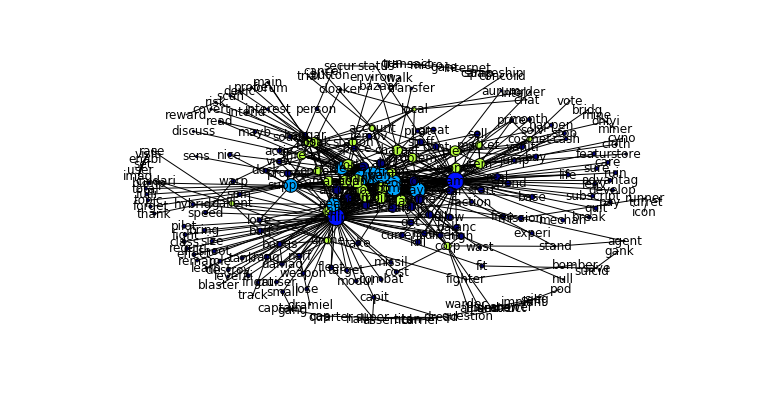

In [78]:
nx.draw_spring(G,with_labels=True,node_size=1000*df['eigen_centrality'],node_color=sc.labels_)

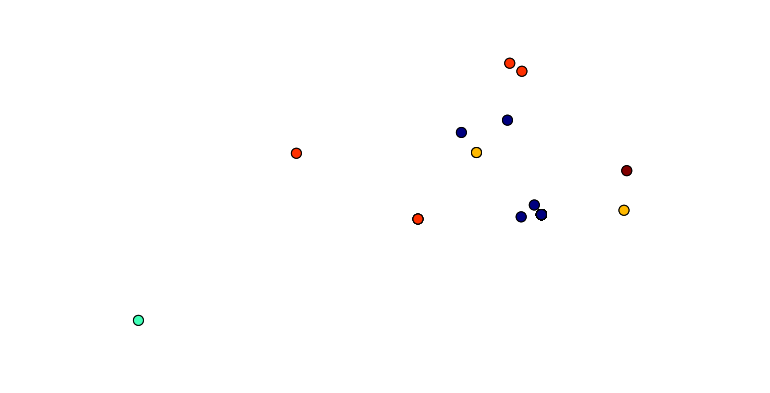

In [79]:
nx.draw_spectral(G,node_size=100,node_color=sc.labels_)

In [80]:
# given: list of nodes (N), and list of edges E=(u,v), get the list of edges that intersects with nodes in N
top_link_weights_df[top_link_weights_df['node_i'].isin(community_nodes)]

,links,weights,node_i,node_j
941346,"(great, idea)",8.214386,great,idea
804066,"(propos, support)",7.829521,propos,support
1433763,"(fulli, support)",6.249609,fulli,support
1479413,"(price, cosmet)",6.089631,price,cosmet
1501933,"(look, like)",6.055077,look,like
186801,"(bonus, ship)",5.986405,bonus,ship
1496514,"(carrier, super)",5.581904,carrier,super
1578113,"(fleet, ship)",5.444872,fleet,ship
741542,"(faction, stand)",5.096717,faction,stand
1543134,"(topic, support)",4.964602,topic,support


In [81]:
which = lambda lst:list(np.where(lst)[0])


# community_nodes = ['transact', 'micro']
# ni = top_link_weights_df['node_i']
# nj = top_link_weights_df['node_j']
# matches = [True for x in ni if x in community_nodes]
# matches

In [82]:
documents.loc[idx][0]

'supported.'

# Next Steps
1. Look more at the forumns / stuff qualitatively
2. Develop a qualitative nomological network
3. perhaps use some emergent constructs from the findings above (e.g. types of posts, themes, etc.) but be very open to seeing new constructs that cannot be seen directly from the vocab (e.g. power, old-guard, crowd, etc.)
4. Think about how to integrate emerging ideas & constructs with this text analysis. 
    1. Filtering (e.g. by key-word)
    2. By Negativity?
    3. Modeling? PCA - negativity?
    